# <center>Lung Cancer treatment demo</center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introdution" data-toc-modified-id="Introdution-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introdution</a></span></li><li><span><a href="#Idea" data-toc-modified-id="Idea-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Idea</a></span></li><li><span><a href="#Exploring-Data" data-toc-modified-id="Exploring-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploring Data</a></span></li><li><span><a href="#2D-Processing-Image" data-toc-modified-id="2D-Processing-Image-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>2D Processing Image</a></span></li><li><span><a href="#Segmentation-of-Lungs" data-toc-modified-id="Segmentation-of-Lungs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Segmentation of Lungs</a></span></li><li><span><a href="#3D-Bone-and-Lung" data-toc-modified-id="3D-Bone-and-Lung-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>3D Bone and Lung</a></span></li><li><span><a href="#UNET" data-toc-modified-id="UNET-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>UNET</a></span></li><li><span><a href="#Another-3D-CNN-idea" data-toc-modified-id="Another-3D-CNN-idea-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Another 3D CNN idea</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#-----------------------------------DRAFT--------------------------------------------" data-toc-modified-id="-----------------------------------DRAFT---------------------------------------------10"><span class="toc-item-num">10&nbsp;&nbsp;</span>---------------------------------- DRAFT--------------------------------------------</a></span></li><li><span><a href="#3D-https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial" data-toc-modified-id="3D-https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>3D <a href="https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial" target="_blank">https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial</a></a></span></li><li><span><a href="#Segmentation-of-Lungs" data-toc-modified-id="Segmentation-of-Lungs-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Segmentation of Lungs</a></span></li><li><span><a href="#Dice-Ceofficient-Cost-function-for-Segmentation" data-toc-modified-id="Dice-Ceofficient-Cost-function-for-Segmentation-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Dice Ceofficient Cost function for Segmentation</a></span></li><li><span><a href="#Nodule-Candidate/Region-of-Interest-Generation¶" data-toc-modified-id="Nodule-Candidate/Region-of-Interest-Generation¶-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Nodule Candidate/Region of Interest Generation¶</a></span></li><li><span><a href="#UNET-for-Candidate-Point-Generation" data-toc-modified-id="UNET-for-Candidate-Point-Generation-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>UNET for Candidate Point Generation</a></span></li></ul></div>

## Introdution

Use Deep Learning and LUNA16 to determine if the patient will be diagnosed with lung cancer.

1. Pre-process the image data
2. Perform data exploration to learn as much about the data (include visualization in 2D, 3D, segmentation)
3. Segmentation with Unet
4. Apply CNN with classification_report to determine the result.
5. Tune the models for better performance.


## Idea

First of all, most parts of this project based on idea of [Deep Convolutional Neural Networks for Lung Cancer Detection](http://cs231n.stanford.edu/reports/2017/pdfs/518.pdf) paper written by Stanford University students. 

**This is my own perspective after reading the paper:**

- The practical Computer-Aided Diagnosis Systems for Lung Cancer pipline is:
    - **Image preprocessing → Detection of cancerous nodule candidates → Nodule candidate false positive reduction → Malignancy prediction for each nodule candidate → Malignancy prediction for overall CT scan** 
    

- The project's Pipeline: **Image processing → Nodule candidates detection → Malignancy classification**
    - **Image processing:** Reduce the complexity of the CT image by segmenting the regions of interests lies inside the lungs rather than the whole information in the CT iamge. Using genarla computer vision technique to mask and get the lung reagion
    
    - **Nodule candidates detection:** The task is to find the candidate regions with nodules since the search space is still very large in the lung. Unet is reccomended model to do this task. This task assist in limit computation and improving speed.
    
    - **Malignancy classification:** use a 3D CNN to perform classification of the nodule which is malignancy or not.
    
**However** after follwing the strategy above, this project stuck in sevral problems, and then some solutions and modifications, which leads to some changes are given to overcome them.


## Exploring Data

In [6]:
!python -m pip install SimpleITK
%matplotlib inline
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tq
from PIL import Image

     |████████████████████████████████| 42.5MB 72kB/s 


There are 89 CT image (represented for 89 person) in the subset0, which will be used to build and test the CAD system.

In [9]:
data_path = "Data"
joinPath = os.path.join
print(joinPath(data_path,"*.mhd"))
file_list = glob(joinPath(data_path,"*.mhd"))
print(len(file_list))
print(file_list)
# Helper function to get rows in data frame associated 
# with each file
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)

Data/*.mhd
89
['Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#import dicom
import scipy.misc
import numpy as np

Moreover, there are also annotations.csv, candidates.csv and candidates_V2.csv files:
    - annotations.csv : coordiante x,y,z and diameter in mm of the nodule.
    
    - candidates.csv : class of each slice in 3D scan image
    
    - candidates_V2.csv: class of each slice in 3D scan image and this version is exteded to help in improvement of false positive prolem.

In [0]:
labels_path = 'labels'
anno_path =  os.path.join(labels_path,'annotations.csv')
cand_path =  os.path.join(labels_path,'candidates.csv')
candv2_path =  os.path.join(labels_path,'candidates_V2.csv')

In [24]:
df_anno = pd.read_csv(anno_path)
df_anno

seriesuid  ...  diameter_mm
0     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...     5.651471
1     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...     4.224708
2     1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...  ...     5.786348
3     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  ...     8.143262
4     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  ...    18.545150
...                                                 ...  ...          ...
1181  1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...  ...     5.053694
1182  1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...  ...     4.556101
1183  1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...  ...     4.357368
1184  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...     4.277203
1185  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...    23.802913

[1186 rows x 5 columns]

=> annotations give 1186 slices with 5 features id, x,y,z coordiante and dimameter of nodule in mm

In [25]:
df_cand = pd.read_csv(cand_path)
df_cand

seriesuid  ...  class
0       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
1       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
2       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
3       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
4       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
...                                                   ...  ...    ...
551060  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...      0
551061  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...      0
551062  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...      0
551063  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...      0
551064  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...      0

[551065 rows x 5 columns]

In [26]:
df_candv2 = pd.read_csv(candv2_path)
df_candv2

seriesuid  ...  class
0       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
1       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
2       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
3       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
4       1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...      0
...                                                   ...  ...    ...
754970  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...      0
754971  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...      0
754972  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...      0
754973  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...      0
754974  1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...  ...      0

[754975 rows x 5 columns]

=> candidate_V2 provide more slices than candidate so the former will be chose for building 3d CNN clasification model

**Each CT image has a lot of slices**

Now one CT image in subset0 will be picked and check its uid in candidate and annoation dataframe

In [27]:
file_list[:5]

['Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd',
 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd',
 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.mhd',
 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd',
 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd']

In [28]:
df_anno[df_anno['seriesuid'] == "1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523"]

seriesuid  ...  diameter_mm
792  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...     5.673454
793  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...     6.275342

[2 rows x 5 columns]

In [29]:
check = df_cand[df_cand['seriesuid'] == "1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523"]
check

seriesuid  ...  class
341456  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
341457  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
341458  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
341459  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
341460  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
...                                                   ...  ...    ...
341950  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
341951  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
341952  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
341953  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
341954  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0

[499 rows x 5 columns]

In [30]:
check[check['class']  == 1]

seriesuid  ...  class
341591  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      1
341926  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      1

[2 rows x 5 columns]

In [31]:
checkv2 = df_candv2[df_candv2['seriesuid'] == "1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523"]
checkv2

seriesuid  ...  class
472235  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
472236  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
472237  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
472238  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
472239  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
...                                                   ...  ...    ...
473010  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
473011  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
473012  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
473013  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0
473014  1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...  ...      0

[780 rows x 5 columns]

In [ ]:
checkv2[checkv2['class']  == 1]

=> candidate_V2 provide more slices than candidate so the former will be chose for building 3d CNN clasification model

**However, number of slices in a CT image different from number of slices in bot candidate and candidate_V2. Therefore, this project base on uid to detect a person who can be or not cancer. It occurs only if 1 slice in candidate has class 1**

In [33]:
file_list_len = len(file_list)
print(file_list_len)
print(df_candv2.shape)
file_list[0]



89
(754975, 5)


'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd'

Because only subset0 CT image used in this project it needs to filter uid of subset0 in candidate v2.

In [34]:
temp = df_candv2.copy()
df_candv2_subset0 = pd.DataFrame()
for i in range(file_list_len):
  uid = file_list[i].split('/')[-1].replace('.mhd','')
  if(temp[temp["seriesuid"] == uid].shape[0]):
   df_candv2_subset0 =  df_candv2_subset0.append(temp[temp['seriesuid'] == uid].copy())

df_candv2_subset0

seriesuid  ...  class
420472  1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231...  ...      0
420473  1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231...  ...      0
420474  1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231...  ...      0
420475  1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231...  ...      0
420476  1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231...  ...      0
...                                                   ...  ...    ...
378672  1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848...  ...      0
378673  1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848...  ...      0
378674  1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848...  ...      0
378675  1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848...  ...      0
378676  1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848...  ...      0

[79135 rows x 5 columns]

=> now number of slices reduced from 754975 to 79135 slices

In [35]:
print(df_anno.shape)


(1186, 5)


**Now the data is visualized to give an observation about them**

In [315]:
df_candv2_subset0['class'].value_counts()

0    78997
1      138
Name: class, dtype: int64

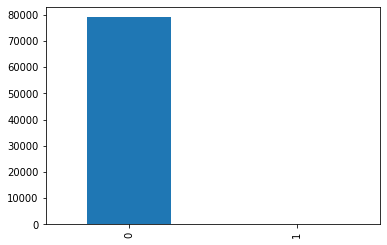

In [309]:

df_candv2_subset0['class'].value_counts().plot(kind='bar')


In [316]:
df_main['cancer'].value_counts()

1    67
0    22
Name: cancer, dtype: int64

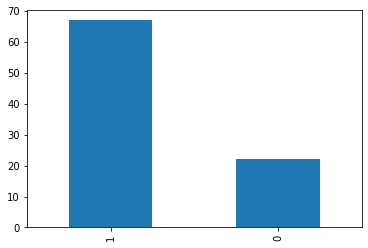

In [317]:
df_main['cancer'].value_counts().plot(kind='bar')


**From the two bar charts above, they shows that there are only 138 positive slice over 79135 slices**

**However, all slices in a CT scan are combined to gether; therefore, the data is imbalance since most of the cases are cancer for subset0**

Now the project filters annotation for segmentation nodule

In [36]:
temp2 = df_anno.copy()
df_anno_subset0 = pd.DataFrame()
for i in range(file_list_len):
  uid = file_list[i].split('/')[-1].replace('.mhd','')
  if(temp2[temp2["seriesuid"] == uid].shape[0]):
   df_anno_subset0 =  df_anno_subset0.append(temp2[temp2['seriesuid'] == uid].copy())

df_anno_subset0

seriesuid  ...  diameter_mm
367   1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986...  ...     8.982987
1030  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786...  ...     6.731879
110   1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637...  ...     6.800249
976   1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896...  ...     3.900928
1141  1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...  ...    21.583112
...                                                 ...  ...          ...
1106  1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324...  ...    17.336250
1084  1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840...  ...    19.653877
620   1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848...  ...     4.683571
621   1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848...  ...     6.242191
622   1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848...  ...    10.831188

[112 rows x 5 columns]

## 2D Processing Image

In [0]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

In [226]:
ct_scan_1st, origin_1st, spacing_1st =  load_itk(file_list[0])
print(ct_scan_1st.shape)
print(origin_1st)
print(spacing_1st)

(123, 512, 512)
[-323.230011 -137.199997 -146.5     ]
[2.5        0.61718798 0.61718798]


In [263]:
ct_scan_1st[50].min()

-3024

In [264]:
ct_scan_1st[50].max()

1506

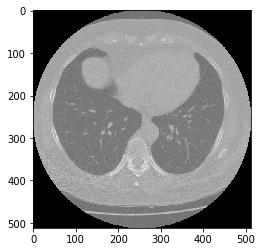

In [262]:
plt.imshow(ct_scan_1st[50], cmap=plt.cm.gray)


plot 20 first slices of an image

To visualise the slices, we will have to plot them. matplotlib is used for plotting the slices. The plot_ct_scan function takes a 3D CT Scanned Image array as input and plots equally spaced slices. The CT Scans are grayscale images i.e. the value of each pixel is a single sample, which means it carries only intensity information.

In [0]:
def plot_ct_scan(scanImg):
    f, plots = plt.subplots(  5, 4, figsize=(20, 20))
    for i in range(0, 20, 1):
        plots[int(i%5), int(i/5)].axis('off')
        k = np.random.randint(0,scanImg.shape[0])
        plots[int(i%5), int(i/5)].imshow(scanImg[k], cmap=plt.cm.gray)

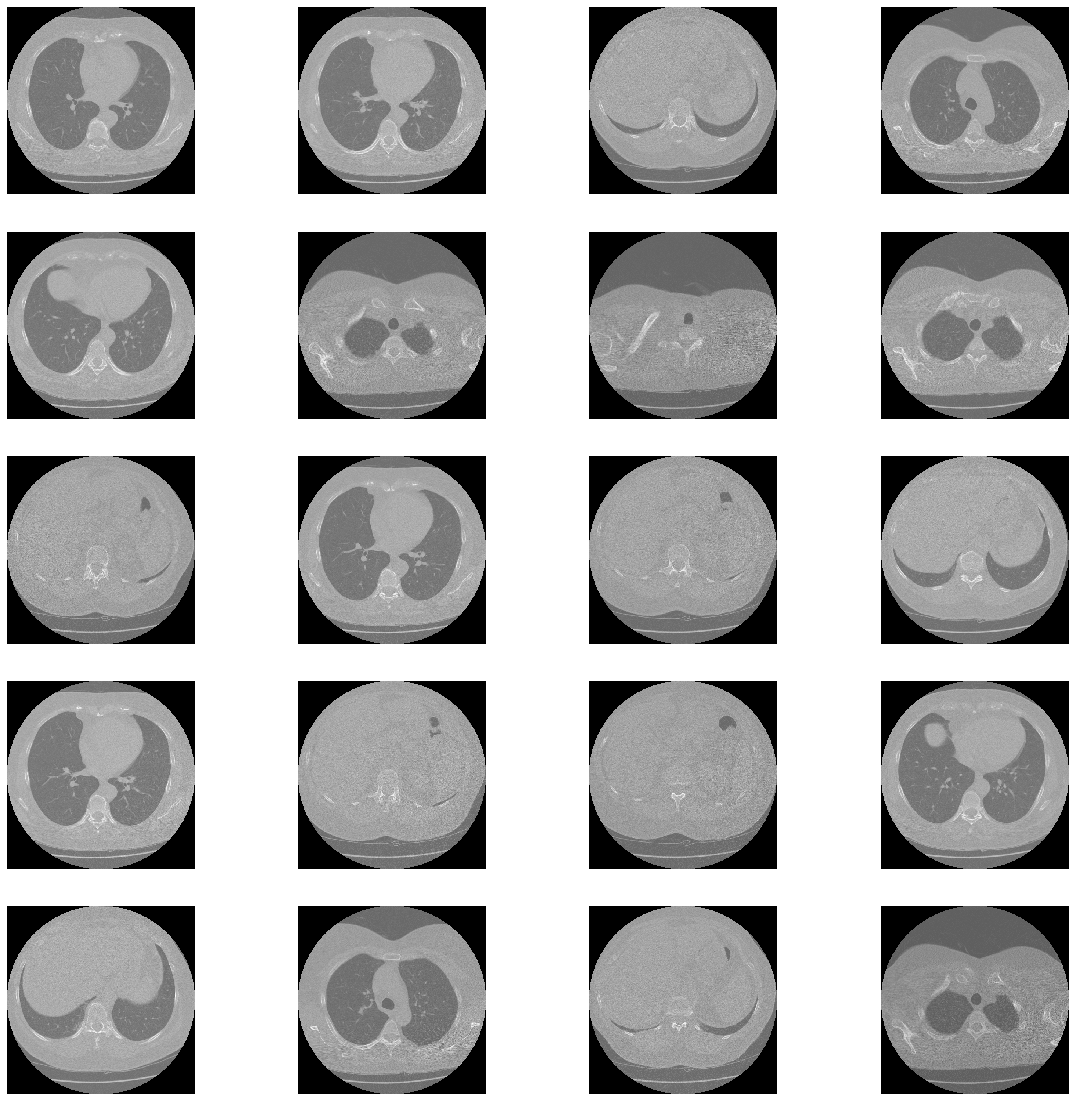

In [231]:
plot_ct_scan(ct_scan_1st)

In [0]:
import os
from moviepy.editor import ImageSequenceClip


def gif(filename, array, fps=15, scale=1.0):
    """Creates a gif given a stack of images using moviepy
    Notes
    -----
    works with current Github version of moviepy (not the pip version)
    https://github.com/Zulko/moviepy/commit/d4c9c37bc88261d8ed8b5d9b7c317d13b2cdf62e
    Usage
    -----
    >>> X = randn(100, 64, 64)
    >>> gif('test.gif', X)
    Parameters
    ----------
    filename : string
        The filename of the gif to write to
    array : array_like
        A numpy array that contains a sequence of images
    fps : int
        frames per second (default: 10)
    scale : float
        how much to rescale each image by (default: 1.0)
    """

    # ensure that the file has the .gif extension
    fname, _ = os.path.splitext(filename)
    filename = fname + '.gif'

    # copy into the color dimension if the images are black and white
    if array.ndim == 3:
        array = array[..., np.newaxis] * np.ones(3)

    # make the moviepy clip
    clip = ImageSequenceClip(list(array), fps=fps).resize(scale)
    clip.write_gif(filename, fps=fps)
    return clip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3407872/45929032 bytes (7.4%)7127040/45929032 bytes (15.5%)11010048/45929032 bytes (24.0%)14843904/45929032 bytes (32.3%)18604032/45929032 bytes (40.5%)22487040/45929032 bytes (49.0%)26378240/45929032 bytes (57.4%)30244864/45929032 bytes (65.9%)34103296/45929032 bytes (74.3%)37978112/45929032 bytes (82.7%)41844736/45929032 bytes (91.1%)45613056/45929032 bytes (99.3%)

In [0]:
clip = gif('test', ct_scan)


[MoviePy] Building file test.gif with imageio


100%|██████████| 133/133 [00:05<00:00, 25.93it/s]


In [0]:
clip

![test](test.gif "football")

## Segmentation of Lungs


After reading the CT Scan, the first step in preprocessing is the segmentation of lung structures because it is obvious that the regions of interests lies inside the lungs. It is visible that the lungs are the darker regions in the CT Scans. The bright region inside the lungs are the blood vessels or air. A threshold of 604(-400 HU) is used at all places because it was found in experiments that it works just fine. We segment lung structures from each slice of the CT Scan image and try not to loose the possible region of interests attached to the lung wall. There are some nodules which may be attached to the lung wall.

![HU.png](HU.png)

The unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this

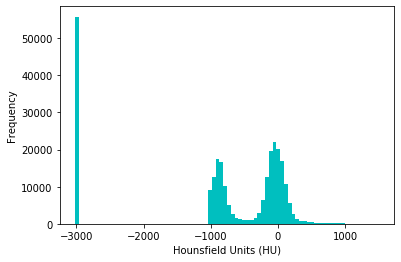

In [265]:

plt.hist(ct_scan_1st[50].flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [0]:
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.filters import roberts, sobel
from scipy import ndimage as ndi
def get_segmented_lungs(image, thresh ,plot=False, dup = True):
    if dup:
      im = image.copy()
    else:
      im = image
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < thresh
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

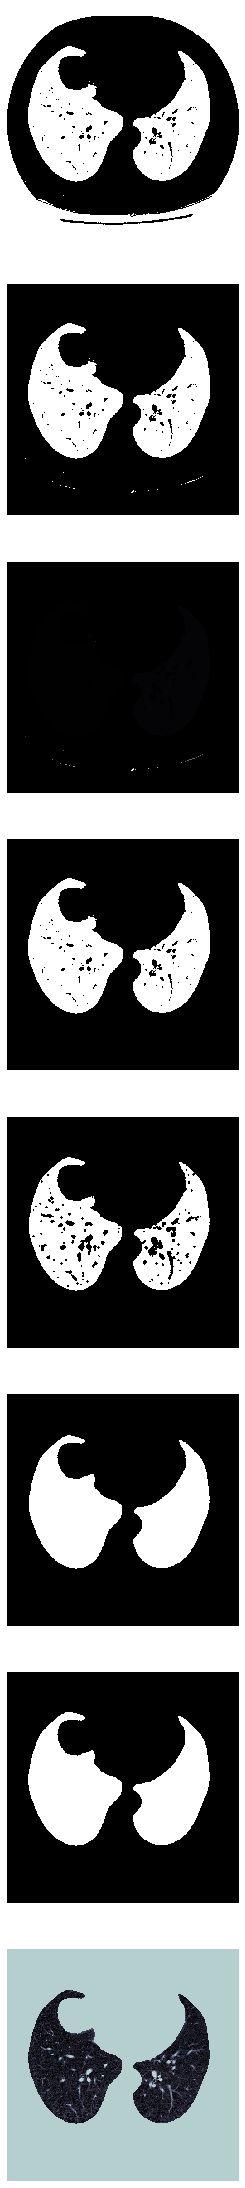

In [268]:
get_segmented_lungs(ct_scan_1st[50], -500 ,True, True)


Now, I will segment the whole CT Scan slice by slice and show some slices of the CT Scan.



In [0]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice,-500,False,True) for slice in ct_scan])

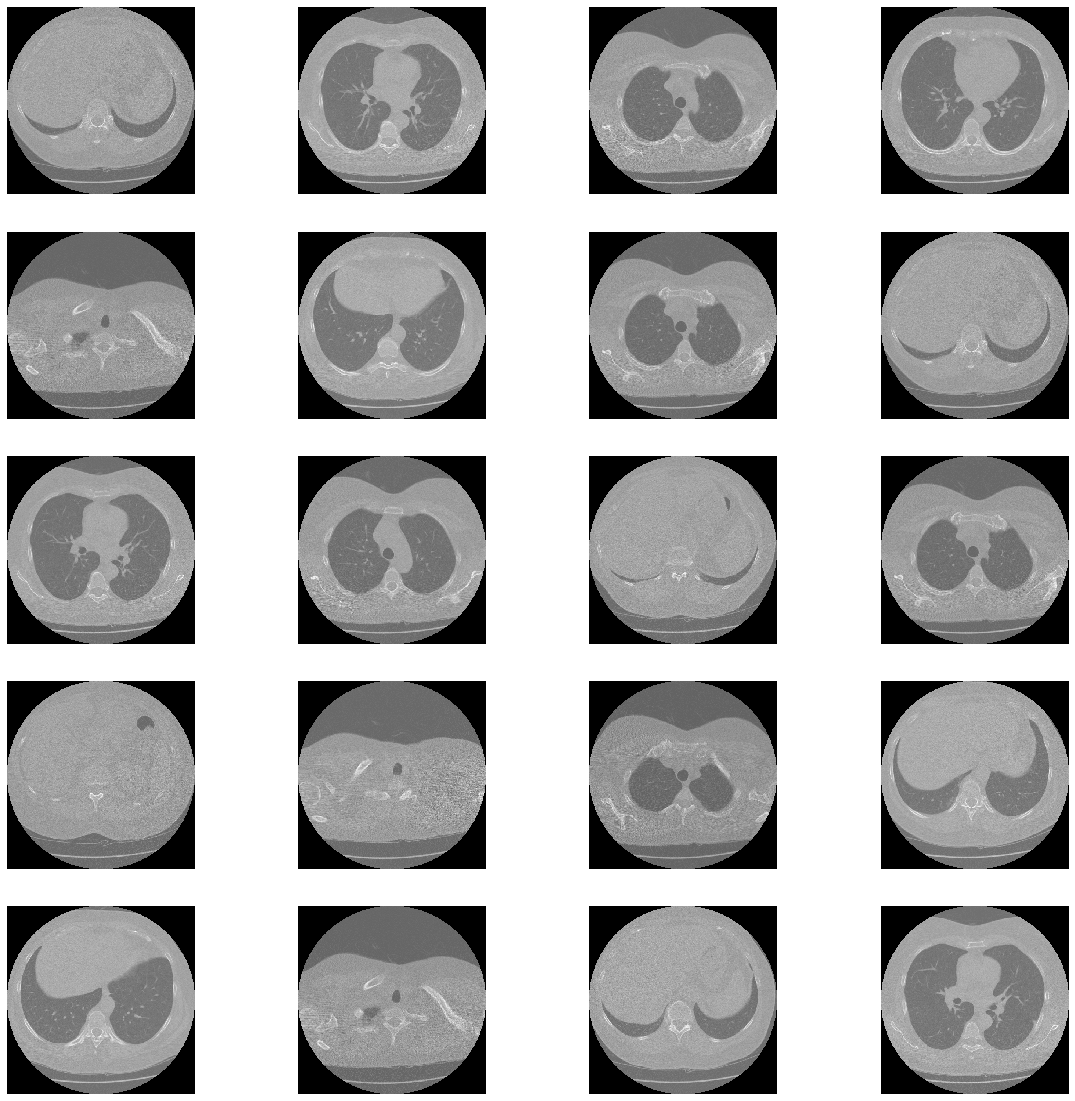

In [51]:
plot_ct_scan(ct_scan_1st)


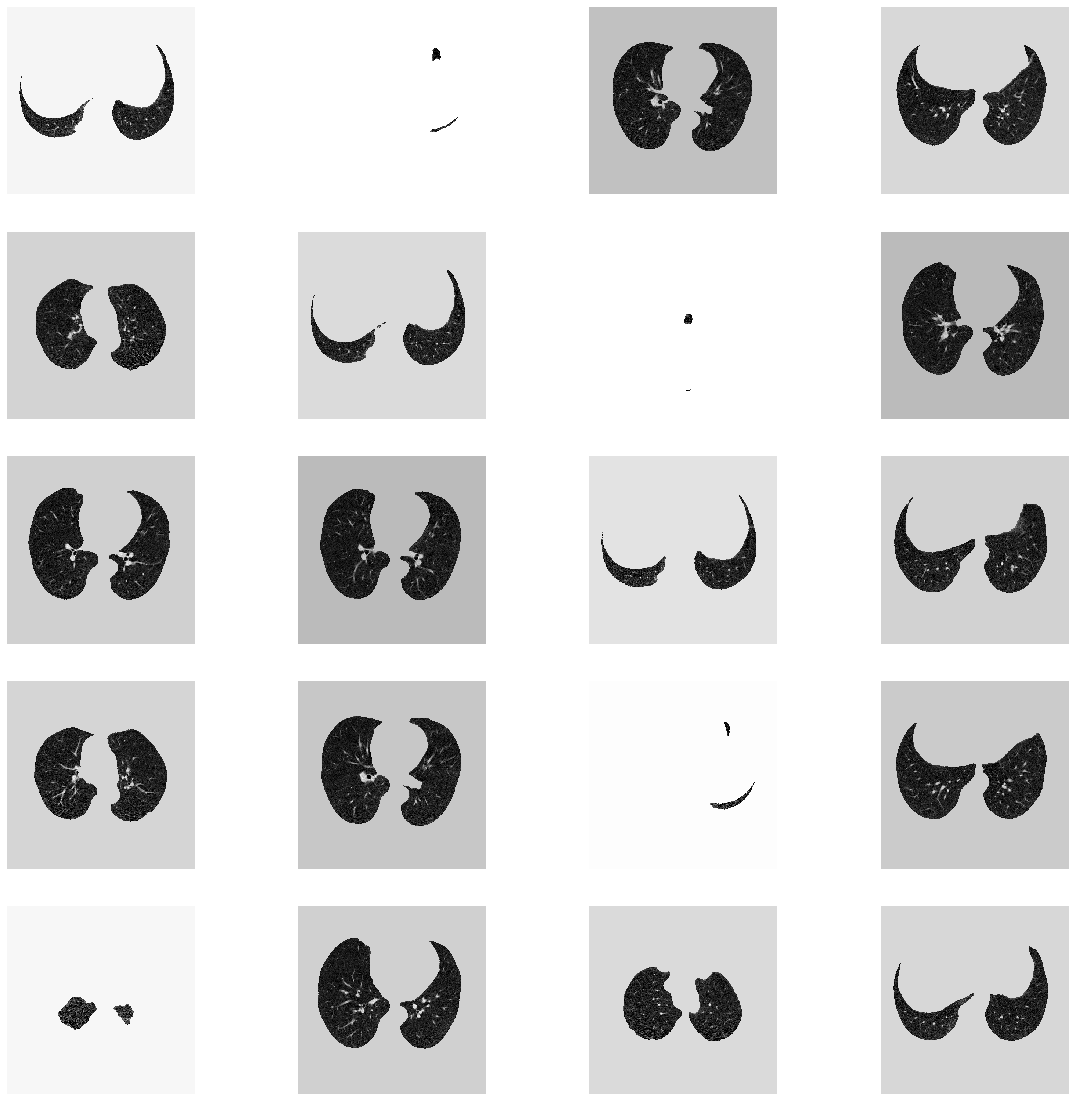

In [52]:
segmented_ct_scan_1st = segment_lung_from_ct_scan(ct_scan_1st)
plot_ct_scan(segmented_ct_scan_1st)


## 3D Bone and Lung

After segmenting the lung structures from the CT Scanned images, our task is to find the candidate regions with nodules since the search space is very large. Also, whole image can't be classified directly using 3D CNNs due to limit on computation, we need to find possible regions of cancer and then classify them. It was found in experiments that all the region of interests have intensity > 604(-400 HU). So, we used this threshold to filter the darker regions. This reduces the number of candidates by a large number and preserves all the important regions with high recall. We then classify all the candidate points to reduce the False Positives.

In [0]:
import scipy.ndimage

def resample(image, spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    #spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [273]:
segmented_ct_scan_1st_resampled, segmented_ct_scan_1st_new_spacing = resample(segmented_ct_scan_1st.copy(), spacing_1st, [1,1,1])
print("Shape before resampling\t", segmented_ct_scan_1st.shape)
print("Shape after resampling\t", segmented_ct_scan_1st_resampled.shape)

Shape before resampling	 (123, 512, 512)
Shape after resampling	 (308, 316, 316)


In [274]:
ct_scan_1st_resampled, ct_scan_1st_new_spacing = resample(ct_scan_1st.copy(), spacing_1st, [1,1,1])
print("Shape before resampling\t", ct_scan_1st.shape)
print("Shape after resampling\t", ct_scan_1st_resampled.shape)

Shape before resampling	 (123, 512, 512)
Shape after resampling	 (308, 316, 316)


In [0]:
from skimage import measure, morphology
#https://stackoverflow.com/questions/54056565/attributeerror-module-skimage-measure-has-no-attribute-marching-cubes
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
#https://stackoverflow.com/questions/56222259/valueerror-unknown-projection-3d-once-again/56222305
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

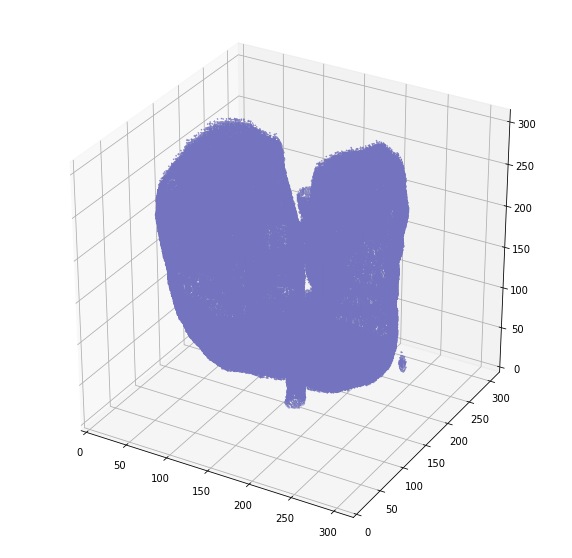

In [280]:
plot_3d(segmented_ct_scan_1st_resampled, 0)

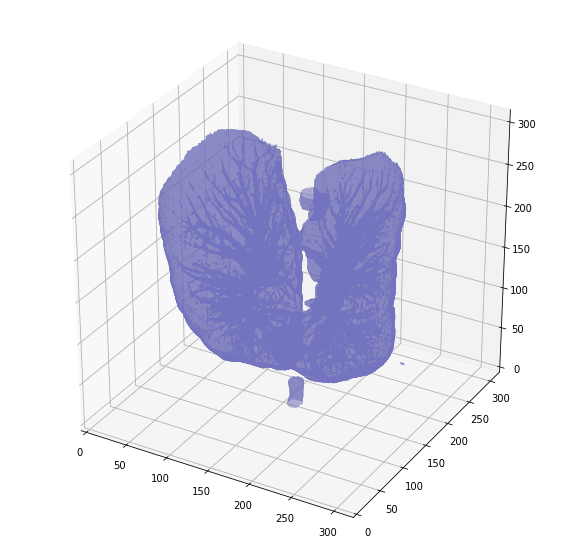

In [281]:
plot_3d(segmented_ct_scan_1st_resampled, -500)

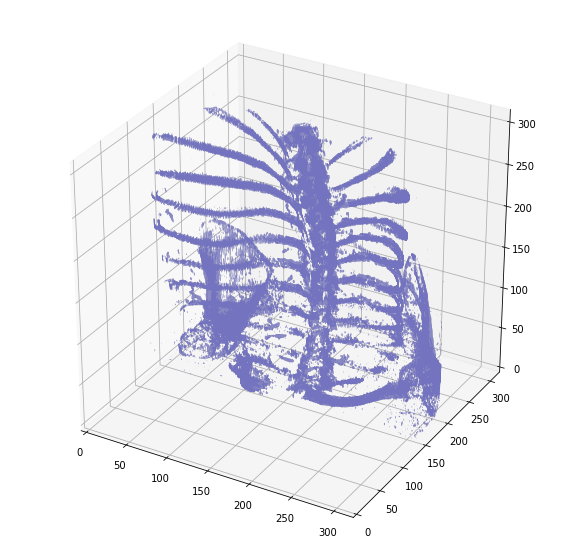

In [279]:
 plot_3d(ct_scan_1st_resampled, 700)

## UNET

In [0]:
'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

After reading the 3D CT Scans, we will first segment the lungs and then generate the binary mask of nodule regions. This will be done by the create_nodule_mask function. The draw_circle function is used to mark the nodule regions in the binary mask. 'cands' are the list of nodule points with the radius given in the annotation.csv file of LUNA16 dataset. At the end we save the resized CT Scan with its segmented lungs and binary mask of nodules.

In [0]:
def seq(start, stop, step=1):
	n = int(round((stop - start)/float(step)))
	if n > 1:
		return([start + step*i for i in range(n+1)])
	else:
		return[]

In [55]:
df_anno_subset0.head()

seriesuid  ...  diameter_mm
367   1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986...  ...     8.982987
1030  1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786...  ...     6.731879
110   1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637...  ...     6.800249
976   1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896...  ...     3.900928
1141  1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...  ...    21.583112

[5 rows x 5 columns]

In [56]:
aa = df_anno_subset0[df_anno_subset0["seriesuid"] == "1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523"].copy()

for b in aa.iterrows():
  print(b)
  print(())
  print(b[1][3])

  print("*****************")

(792, seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...
coordX                                                  -131.399
coordY                                                  -2.75846
coordZ                                                  -221.431
diameter_mm                                              5.67345
Name: 792, dtype: object)
()
-221.43060530000002
*****************
(793, seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102...
coordX                                                   60.4637
coordY                                                   6.68468
coordZ                                                  -166.264
diameter_mm                                              6.27534
Name: 793, dtype: object)
()
-166.26357130000002
*****************


**The space between each slice is different so it need to be rescale to 1x1x1mm**

In [0]:

'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
	#make empty matrix, which will be filled with the mask
  RESIZE_SPACING = [1, 1, 1]
  image_mask = np.zeros(image.shape)
  print("draw circle")
	#run over all the nodules in the lungs
  for ca in cands.iterrows():
    #get middel x-,y-, and z-worldcoordinate of the nodule
    radius = np.ceil(ca[1][4])/2
    coord_x = ca[1][1]
    coord_y = ca[1][2]
    coord_z = ca[1][3]
    image_coord = np.array((coord_z,coord_y,coord_x))

    #determine voxel coordinate given the worldcoordinate
    image_coord = world_2_voxel(image_coord,origin,spacing)

    #determine the range of the nodule
    noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

    #create the mask
    for x in noduleRange:
      for y in noduleRange:
        for z in noduleRange:
          coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
          if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
            image_mask[int(np.round(coords[0])),int(np.round(coords[1])),int(np.round(coords[2]))] = 1

  return image_mask

'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, maskPath, cands):
	#if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
  img, origin, spacing = load_itk(imagePath)
  imageName = imagePath.split('/')[-1].replace('.mhd','')
	#calculate resize factor
  RESIZE_SPACING = [1, 1, 1]
  resize_factor = spacing / RESIZE_SPACING
  new_real_shape = img.shape * resize_factor
  new_shape = np.round(new_real_shape)
  real_resize = new_shape / img.shape
  new_spacing = spacing / real_resize

  #resize image
  lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
  lung_img = lung_img + 1024
  lung_mask = segment_lung_from_ct_scan(lung_img)
  lung_img = lung_img - 1024

  #create nodule mask
  nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

  lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

  original_shape = lung_img.shape	
  for z in range(lung_img.shape[0]):
    offset = (512 - original_shape[1])
    upper_offset = int(np.round(offset/2))
    lower_offset = offset - upper_offset

    new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

    lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
    lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
    nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
  np.save(os.path.join(maskPath ,imageName + '_lung_img.npz'), lung_img_512)
  #np.save(os.path.join(maskPath ,imageName + '_lung_mask.npz'), lung_mask_512)
  np.save(os.path.join(maskPath ,imageName + '_nodule_mask.npz'), nodule_mask_512)

In [0]:
mkdir Unet

In [0]:
imagePath = file_list[0] 
maskPath = "Unet"
create_nodule_mask(imagePath, maskPath, aa)

In [0]:
ls Unet

In [0]:
ass = np.load("Unet/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523_nodule_mask.npz.npy")
plot_ct_scan(ass[83:104])

In [0]:
len(df_anno_subset0['seriesuid'].unique())

In [0]:
mkdir Unet/test


In [0]:
mkdir Unet/train

In [0]:
# def split_unet_data(imgPath, df_anno, test_ratio):
#   total = len(df_anno['seriesuid'].unique())
#   num_train = int(total*(1 - test_ratio))
#   train_path = 'Unet/train'
#   test_path = 'Unet/test'
#   for i in range(num_train):
#     uid = df_anno['seriesuid'].unique()[i]
#     nodules = df_anno[df_anno["seriesuid"] == uid].copy()
#     imagePath = os.path.join("Data",uid+'.mhd')
#     create_nodule_mask(imagePath, train_path, nodules)
  
#   for i in range(numtrain,total,1):
#     uid = df_anno['seriesuid'].unique()[i]
#     nodules = df_anno[df_anno["seriesuid"] == uid].copy()
#     imagePath = os.path.join("Data",uid+'.mhd')
#     create_nodule_mask(imagePath, test_path, nodules)
  

In [58]:
split_unet_data(None, df_anno_subset0, 0.1)

NameError: ignored

In [0]:
ls Unet

In [0]:
# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
	return -dice_coef(y_true, y_pred)

'''
The UNET model is compiled in this function.
'''
def unet_model():
	inputs = Input((1, 512, 512))
	conv1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(inputs)
	conv1 = Dropout(0.2)(conv1)
	conv1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv1)
	pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

	conv2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool1)
	conv2 = Dropout(0.2)(conv2)
	conv2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv2)
	pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

	conv3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool2)
	conv3 = Dropout(0.2)(conv3)
	conv3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv3)
	pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

	conv4 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool3)
	conv4 = Dropout(0.2)(conv4)
	conv4 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv4)
	pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

	conv5 = Convolution2D(1024, 3, 3, activation='relu', border_mode='same')(pool4)
	conv5 = Dropout(0.2)(conv5)
	conv5 = Convolution2D(1024, 3, 3, activation='relu', border_mode='same')(conv5)

	up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
	conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(up6)
	conv6 = Dropout(0.2)(conv6)
	conv6 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv6)

	up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
	conv7 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up7)
	conv7 = Dropout(0.2)(conv7)
	conv7 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv7)

	up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
	conv8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up8)
	conv8 = Dropout(0.2)(conv8)
	conv8 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv8)

	up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
	conv9 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up9)
	conv9 = Dropout(0.2)(conv9)
	conv9 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv9)

	conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

	model = Model(input=inputs, output=conv10)
	model.summary()
	model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

	return model

In [0]:
def train_and_predict(use_existing):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train = np.load(working_path+"trainImages.npy").astype(np.float32)
    imgs_mask_train = np.load(working_path+"trainMasks.npy").astype(np.float32)

    imgs_test = np.load(working_path+"testImages.npy").astype(np.float32)
    imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)
    
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean  # images should already be standardized, but just in case
    imgs_train /= std

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    # Saving weights to unet.hdf5 at checkpoints
    model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)
    #
    # Should we load existing weights? 
    # Set argument for call to train_and_predict to true at end of script
    if use_existing:
        model.load_weights('unet.hdf5')
        
    # 
    # The final results for this tutorial were produced using a multi-GPU
    # machine using TitanX's.
    # For a home GPU computation benchmark, on my home set up with a GTX970 
    # I was able to run 20 epochs with a training set size of 320 and 
    # batch size of 2 in about an hour. I started getting reseasonable masks 
    # after about 3 hours of training. 
    #
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=20, verbose=1, shuffle=True,
              callbacks=[model_checkpoint])

    # loading best weights from training session
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('unet.hdf5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    num_test = len(imgs_test)
    imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0)[0]
    np.save('masksTestPredicted.npy', imgs_mask_test)
    mean = 0.0
    for i in range(num_test):
        mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])
    mean/=num_test
    print("Mean Dice Coeff : ",mean)

<font color=red>**However, when lung mask and lung image are generated in order to go through Unet to train segmentation lung model, this project is built on google colab GPU notebook (which only ~70gb) and it is not enough space for generating data**</font>

**=> There this step is ignore and try another way for classifying cancer person**

In [0]:
#################### NEW

## Another 3D CNN idea

<font color='red'>**Threre is another idea to keep reducing complexity of CT image from [Harrison](https://pythonprogramming.net/3d-convolutional-neural-network-machine-learning-tutorial/) by reduce the image size to 50*50 and reduce number of slices of each CT image to the same which is 20**</font>

In [59]:
df_candv2_subset0.shape

(79135, 5)

In [0]:
uid_list = df_candv2_subset0['seriesuid'].unique()

In [61]:
df_candv2_subset0[df_candv2_subset0["seriesuid"] == uid_list[1]]['class'].sum()

1

In [0]:
df_main = pd.DataFrame(columns=['uid', 'cancer'])
df_dict = {}
df_dict['uid'] = []
df_dict['cancer'] = []

id_list = []
lable_list = []
for i in range(len(uid_list)):
  cancer = df_candv2_subset0[df_candv2_subset0["seriesuid"] == uid_list[i]]['class'].sum()
  if cancer == 0:
    df_dict['uid'].append(uid_list[i])
    df_dict['cancer'].append(0)
  else:
    df_dict['uid'].append(uid_list[i])
    df_dict['cancer'].append(1)


In [0]:
df_main = pd.DataFrame(df_dict)

In [64]:
df_main

uid  cancer
0   1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231...       0
1   1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986...       1
2   1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797...       0
3   1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011...       0
4   1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786...       1
..                                                ...     ...
84  1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421...       1
85  1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256...       1
86  1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324...       1
87  1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840...       1
88  1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848...       1

[89 rows x 2 columns]

In [0]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk_hope(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    # origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # # Read the spacing along each dimension
    # spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan

In [67]:
file_list[0]

'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd'

In [0]:
def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

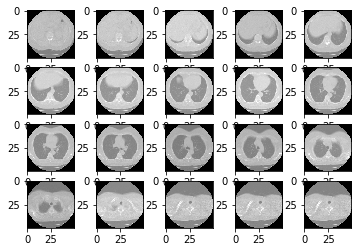

In [324]:
import cv2
import math
#f = file_list.copy()
labels_df = df_main.copy()

IMG_PX_SIZE = 50
HM_SLICES = 20
for patient in uid_list[:1]:
    label = labels_df[labels_df['uid'] == patient]['cancer']
    slices = load_itk_hope(file_list[0])
    #slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    slices = [cv2.resize(np.array(each_slice),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()

In [325]:
label

0    0
Name: cancer, dtype: int64

In [71]:
len(new_slices)

20

In [72]:
int(labels_df[labels_df['uid'] == uid_list[0]]['cancer'])

0

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import math

IMG_SIZE_PX = 50
SLICE_COUNT = 20

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = int(labels_df[labels_df['uid'] == patient]['cancer'])
    slices = load_itk_hope("Data/" + patient +'.mhd' )
    

    new_slices = []
    slices = [cv2.resize(np.array(each_slice),(img_px_size,img_px_size)) for each_slice in slices]

    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()
    #print("ok")
    if label == 1: 
      label=np.array([0,1])
     # print('ok1')
    elif label == 0: 
      label=np.array([1,0])
      #print('ok12')
    
    
    return np.array(new_slices),label



In [75]:

patients = uid_list.copy()
labels_df = df_main.copy()
IMG_SIZE_PX = 50
SLICE_COUNT = 20
much_data = []
for num,patient in enumerate(patients):
    if num % 10 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels_df,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)

0
10
20
30
40
50
60
70
80


In [0]:
import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [0]:
much_data = np.load('muchdata-50-50-20.npy',allow_pickle=True)
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:80]
validation_data = much_data[80:]

In [0]:
def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels = y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(cost)
    
    hm_epochs = 30
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            for data in train_data:
                total_runs += 1
                try:
                    epoch_loss = 0
                    X = data[0]
                    Y = data[1]
                    #print(Y)
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_run += 1
                except Exception as e:
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)


train_neural_network(x)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D
from keras.utils import np_utils
from keras import backend as K

from tensorflow.keras import datasets, layers, models
'''
Creates a keras model with 3D CNNs and returns the model.
'''
def classifier(input_shape, kernel_size, pool_size):
	model = Sequential()

	model.add(Convolution3D(32, kernel_size[0], kernel_size[1], kernel_size[2],
	                        border_mode='valid',
	                        input_shape=input_shape))
	model.add(Activation('relu'))
	model.add(MaxPooling3D(pool_size=pool_size, strides=[2,2,2], padding = 'same'))
	model.add(Convolution3D(64, kernel_size[0], kernel_size[1], kernel_size[2]))
	model.add(Activation('relu'))
	model.add(MaxPooling3D(pool_size=pool_size, strides=[2,2,2], padding = 'same'))
	
  
	model.add(Dropout(0.25))

	model.add(Flatten())
	model.add(Dense(512))
	model.add(Activation('relu'))
	model.add(Dropout(0.5))
	model.add(Dense(128))
	model.add(Activation('relu'))
	model.add(Dropout(0.5))
	model.add(Dense(2))
	model.add(Activation('softmax'))

	return model

def train_classifier(input_shape):
	model = classifier(input_shape, (3, 3, 3), (2, 2, 2))
	model.compile(loss='categorical_crossentropy',
		  #optimizer='adadelta',
      optimizer='adam',
		  metrics=['accuracy'])
	'''
	Read the preprocessed datafiles chunk by chunnk and train the model on that batch (trainX, trainY) using:'''
	model.train_on_batch(trainX, trainY, sample_weight=None)
	'''The model can be trained on many epochs using for loops'''
	
	'''
	AFter training the dataset we test our model of the test dataset, read the test file chunk by chunk and 
	test on each chunk (trainX, trainY) using:'''
	print (model.test_on_batch(trainX, trainY, sample_weight=None))
	'''The average of all of this can be taken to obtain the final test score.'''
	
	'''After testing save the model using'''
	model.save('my_model.h5')

In [0]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten
# from keras.layers import Convolution3D, MaxPooling3D
# from keras.utils import np_utils
# from keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution3D, MaxPooling3D, BatchNormalization
'''
Creates a keras model with 3D CNNs and returns the model.
'''
def classifier(input_shape, kernel_size, pool_size):
  model = models.Sequential()

  model.add(Convolution3D(32, (kernel_size[0], kernel_size[1], kernel_size[2]),input_shape=input_shape, activation='relu'))
  #model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=pool_size, strides=[2,2,2], padding = 'same'))
  model.add(BatchNormalization())

  model.add(Convolution3D(64, (kernel_size[0], kernel_size[1], kernel_size[2]),input_shape=input_shape, activation='relu'))
  #model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=pool_size, strides=[1,1,1], padding = 'same'))
  model.add(BatchNormalization())

  model.add(Convolution3D(64, (kernel_size[0], kernel_size[1], kernel_size[2]),input_shape=input_shape, activation='relu'))
  #model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=pool_size, strides=[1,1,1], padding = 'same'))
  model.add(BatchNormalization())

  model.add(Convolution3D(64, (kernel_size[0], kernel_size[1], kernel_size[2]),input_shape=input_shape, activation='relu'))
  #model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=pool_size, strides=[1,1,1], padding = 'same'))
  model.add(BatchNormalization())

  model.add(Convolution3D(64, (kernel_size[0], kernel_size[1], kernel_size[2]),input_shape=input_shape, activation='relu'))
  #model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=pool_size, strides=[2,2,2], padding = 'same'))
  model.add(BatchNormalization())

  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.7))
  model.add(Dense(128))
  model.add(Activation('relu'))
  model.add(Dropout(0.7))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model

def train_classifier(input_shape):
  model = classifier(input_shape, (3, 3, 3), (2, 2, 2))
  model.compile(loss='categorical_crossentropy',
      #optimizer='adadelta',
      optimizer='adam',
      metrics=['accuracy'])
  '''
  Read the preprocessed datafiles chunk by chunnk and train the model on that batch (trainX, trainY) using:'''
  model.train_on_batch(trainX, trainY, sample_weight=None)
  '''The model can be trained on many epochs using for loops'''

  '''
  AFter training the dataset we test our model of the test dataset, read the test file chunk by chunk and 
  test on each chunk (trainX, trainY) using:'''
  print (model.test_on_batch(trainX, trainY, sample_weight=None))
  '''The average of all of this can be taken to obtain the final test score.'''

  '''After testing save the model using'''
  model.save('my_model.h5')

In [270]:
mymodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 18, 48, 48, 32)    896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 24, 24, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 24, 24, 32)     128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 22, 22, 64)     55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 22, 22, 64)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 22, 22, 64)     256       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 20, 20, 64)     1

In [0]:
trainX = train_data[:,0]
trainY = train_data[:,1]
valX = validation_data[:,0]
valY = validation_data[:,1]

In [0]:
a = np.zeros((80,20,50,50,1))
for i in range(len(trainX)):
  a[i,:,:,:] = trainX[i].reshape(20,50,50,1)

In [125]:
valY[0].shape

()

In [0]:
c = np.zeros((9,20,50,50,1))
for i in range(len(valX)):
  c[i,:,:,:] = valX[i].reshape(20,50,50,1)

In [0]:
trainX = a
valX = c

In [126]:
trainY[0].shape

()

In [0]:
b = np.zeros((80,2))
for i in range(len(trainY)):
  b[i,:] = trainY[i].reshape(2,)

In [0]:
d = np.zeros((9,2))
for i in range(len(valY)):
  d[i,:] = valY[i].reshape(2,)

In [0]:
trainY = b
valY = d

In [0]:
trainY1 = train_data[:,1]
trainY = []
for aaa in trainY1:
  trainY.append(aaa[0])

valY1 = validation_data[:,1]
valY = []
for bbb in valY1:
  valY.append(bbb[0])

In [0]:
tf.reset_default_graph()

mymodel = classifier((20,50,50,1), (3, 3, 3), (2, 2, 2))

In [212]:
mymodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = mymodel.fit(trainX, np.array(trainY), batch_size=10 ,epochs=10 , steps_per_epoch=1,
                      validation_data=(valX, np.array(valY)), validation_steps=1, class_weight={0: 0.3, 1: 0.7})
#history = mymodel.fit(trainX, np.array(trainY), batch_size=10 ,epochs=10, class_weight={0: 0.2, 1: 0.8} )

Train on 1 samples, validate on 9 samples
Epoch 1/10
1/1 [==============================] - 1s 746ms/step - loss: 1.1548 - acc: 0.3125 - val_loss: 8.7521 - val_acc: 0.1111
Epoch 2/10
1/1 [==============================] - 0s 134ms/step - loss: 0.7730 - acc: 0.5500 - val_loss: 3.6967 - val_acc: 0.1111
Epoch 3/10
1/1 [==============================] - 0s 132ms/step - loss: 0.8451 - acc: 0.5250 - val_loss: 0.4298 - val_acc: 0.8889
Epoch 4/10
1/1 [==============================] - 0s 134ms/step - loss: 0.5258 - acc: 0.6250 - val_loss: 0.9725 - val_acc: 0.8889
Epoch 5/10
1/1 [==============================] - 0s 134ms/step - loss: 0.6386 - acc: 0.6125 - val_loss: 1.8937 - val_acc: 0.7778
Epoch 6/10
1/1 [==============================] - 0s 133ms/step - loss: 0.5400 - acc: 0.6250 - val_loss: 2.6826 - val_acc: 0.6667
Epoch 7/10
1/1 [==============================] - 0s 133ms/step - loss: 0.6529 - acc: 0.5875 - val_loss: 4.2597 - val_acc: 0.6667
Epoch 8/10
1/1 [==============================] 

In [0]:
mymodel.save('finalmodel.h5')

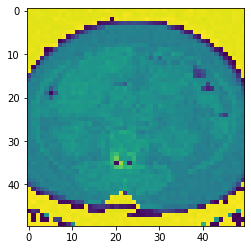

In [269]:
plt.imshow(np.squeeze(trainX[20][0]))

In [0]:
yhat = mymodel.predict(trainX)
yhat = np.squeeze(np.where(yhat > 0.5, 1, 0))

In [214]:
yhat

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1])

<font color=red>**The process extract label before training gives swap label**</font>

<font color=red>**cancer: 0, no cancer: 1**</font>

In [215]:

from sklearn.metrics import classification_report
print(classification_report(trainY, yhat))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        59
           1       0.58      0.71      0.64        21

    accuracy                           0.79        80
   macro avg       0.73      0.76      0.74        80
weighted avg       0.81      0.79      0.79        80



**=> The system detect cancer case better than case of no cancer, it is easy to understand that this dataset is imbalance**

**f1 score for cancer case is 85% which can be good socre because the data only has 89 samples**

**f1 score for no cancer case is 64% which can be acceptable because the data only has 89 samples**

**However, the accuracy of validation set is only ~55%, the modle need to be improved more to get better result**

In [323]:
sum(trainY)

21

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    #plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])

    plt.legend()

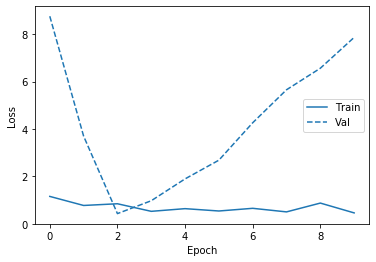

In [300]:
plot_metrics(history)


The best one can be at Epoch 3 (2+1)

**=> This model is tunned and modified differ from original of Harrision**

**- Add weigh_class to deal with imbalance problem**

**- Modify to give the distribution of input similar to distribution of output to improve performance**

**- use binary classification to use weight_class to overcome imbalance**

**- Add more conv and pooling layers**

## Conclusion

First of all, most parts of this project based on idea of [Deep Convolutional Neural Networks for Lung Cancer Detection](http://cs231n.stanford.edu/reports/2017/pdfs/518.pdf) paper written by Stanford University students. 

**This is my own perspective after reading the paper:**

- The practical Computer-Aided Diagnosis Systems for Lung Cancer pipline is:
    - **Image preprocessing → Detection of cancerous nodule candidates → Nodule candidate false positive reduction → Malignancy prediction for each nodule candidate → Malignancy prediction for overall CT scan** 
    

- The project's Pipeline: **Image processing → Nodule candidates detection → Malignancy classification**
    - **Image processing:** Reduce the complexity of the CT image by segmenting the regions of interests lies inside the lungs rather than the whole information in the CT iamge. Using genarla computer vision technique to mask and get the lung reagion
    
    - **Nodule candidates detection:** The task is to find the candidate regions with nodules since the search space is still very large in the lung. Unet is reccomended model to do this task. This task assist in limit computation and improving speed.
    
    - **Malignancy classification:** use a 3D CNN to perform classification of the nodule which is malignancy or not.
    
**However** after follwing the strategy above, this project stuck in sevral problems

**Threre is another idea to keep reducing complexity of CT image from [Harrison](https://pythonprogramming.net/3d-convolutional-neural-network-machine-learning-tutorial/) by reduce the image size to 50*50 and reduce number of slices of each CT image to the same which is 20**

**=> This model is tunned and modified differ from original of Harrision**

**- Add weigh_class to deal with imbalance problem**

**- Modify to give the distribution of input similar to distribution of output to improve performance**

**- use binary classification to use weight_class to overcome imbalance**

**- Add more conv and pooling layers**

**=> The system detect cancer case better than case of no cancer, it is easy to understand that this dataset is imbalance**

**f1 score for cancer case is 85% which can be good socre because the data only has 89 samples**

**f1 score for no cancer case is 64% which can be acceptable because the data only has 89 samples**

**However, the accuracy of validation set is only ~55%, the modle need to be improved more to get better result**

<font color='red'>Some recommend solutions: </font>
    
   - **Augment data for both cancer and no cancer case to ~10000 sample for each one**
   - **Resize slice to bigger size instead of (50x50)**
   - **Try segment nodule befor pass it to 3D CNN model**

## ---------------------------------- DRAFT--------------------------------------------

from keras.layers import Convolution3D, MaxPooling3D
mmuch_data[0][1]

In [0]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten
# from keras.layers import Convolution3D, MaxPooling3D
# from keras.utils import np_utils
# from keras import backend as K

# '''
# Creates a keras model with 3D CNNs and returns the model.
# '''
# def classifier(input_shape, kernel_size, pool_size):
# 	model = Sequential()

# 	model.add(Convolution3D(16, kernel_size[0], kernel_size[1], kernel_size[2],
# 	                        border_mode='valid',
# 	                        input_shape=input_shape))
# 	model.add(Activation('relu'))
# 	model.add(MaxPooling3D(pool_size=pool_size))
# 	model.add(Convolution3D(32, kernel_size[0], kernel_size[1], kernel_size[2]))
# 	model.add(Activation('relu'))
# 	model.add(MaxPooling3D(pool_size=pool_size))
# 	model.add(Convolution3D(64, kernel_size[0], kernel_size[1], kernel_size[2]))
# 	model.add(Activation('relu'))
# 	model.add(MaxPooling3D(pool_size=pool_size))
# 	model.add(Dropout(0.25))

# 	model.add(Flatten())
# 	model.add(Dense(512))
# 	model.add(Activation('relu'))
# 	model.add(Dropout(0.5))
# 	model.add(Dense(128))
# 	model.add(Activation('relu'))
# 	model.add(Dropout(0.5))
# 	model.add(Dense(2))
# 	model.add(Activation('softmax'))

# 	return model

# def train_classifier(input_shape):
# 	model = classifier(input_shape, (3, 3, 3), (2, 2, 2))
# 	model.compile(loss='categorical_crossentropy',
# 		  optimizer='adadelta',
# 		  metrics=['accuracy'])
# 	'''
# 	Read the preprocessed datafiles chunk by chunnk and train the model on that batch (trainX, trainY) using:'''
# 	model.train_on_batch(trainX, trainY, sample_weight=None)
# 	'''The model can be trained on many epochs using for loops'''
	
# 	'''
# 	AFter training the dataset we test our model of the test dataset, read the test file chunk by chunk and 
# 	test on each chunk (trainX, trainY) using:'''
# 	print (model.test_on_batch(trainX, trainY, sample_weight=None))
# 	'''The average of all of this can be taken to obtain the final test score.'''
	
# 	'''After testing save the model using'''
# 	model.save('my_model.h5')

In [327]:
train_data[:,1]

array([array([1, 0]), array([0, 1]), array([1, 0]), array([1, 0]),
       array([0, 1]), array([0, 1]), array([1, 0]), array([0, 1]),
       array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]),
       array([0, 1]), array([0, 1]), array([1, 0]), array([1, 0]),
       array([1, 0]), array([1, 0]), array([0, 1]), array([0, 1]),
       array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]),
       array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]),
       array([0, 1]), array([1, 0]), array([0, 1]), array([0, 1]),
       array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]),
       array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]),
       array([1, 0]), array([0, 1]), array([0, 1]), array([1, 0]),
       array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]),
       array([0, 1]), array([0, 1]), array([1, 0]), array([0, 1]),
       array([1, 0]), array([0, 1]), array([0, 1]), array([0, 1]),
       array([0, 1]), array([0, 1]), array([0, 1]), array([1, 

In [0]:
trainY1 = train_data[:,1]
trainY = []
for aaa in trainY1:
  trainY.append(aaa[0])

valY1 = validation_data[:,1]
valY = []
for bbb in valY1:
  valY.append(bbb[0])

In [0]:
trainX = train_data[:,0]
trainY = train_data[:,1]
valX = validation_data[:,0]
valY = validation_data[:,1]

In [0]:
a = np.zeros((80,20,50,50,1))
for i in range(len(trainX)):
  a[i,:,:,:] = trainX[i].reshape(20,50,50,1)

In [125]:
valY[0].shape

()

In [0]:
c = np.zeros((9,20,50,50,1))
for i in range(len(valX)):
  c[i,:,:,:] = valX[i].reshape(20,50,50,1)

In [0]:
trainX = a
valX = c

In [126]:
trainY[0].shape

()

In [0]:
b = np.zeros((80,2))
for i in range(len(trainY)):
  b[i,:] = trainY[i].reshape(2,)

In [0]:
d = np.zeros((9,2))
for i in range(len(valY)):
  d[i,:] = valY[i].reshape(2,)

In [0]:
trainY = b
valY = d

In [0]:
def train_classifier(input_shape):
	model = classifier(input_shape, (3, 3, 3), (2, 2, 2))
	model.compile(loss='binary_crossentropy',
		  optimizer='adam',
		  metrics=['accuracy'])
	'''
	Read the preprocessed datafiles chunk by chunnk and train the model on that batch (trainX, trainY) using:'''
	model.train_on_batch(trainX, trainY, sample_weight=None)
	'''The model can be trained on many epochs using for loops'''
	for e in range(20):
		model.train_on_batch(trainX, trainY, sample_weight=None)
		print("yes")
		print (model.test_on_batch(trainX, trainY, sample_weight=None))
		print(model.metrics_names)	
	'''
	AFter training the dataset we test our model of the test dataset, read the test file chunk by chunk and 
	test on each chunk (trainX, trainY) using:'''
		#print("yes")
		#print (model.test_on_batch(trainX, trainY, sample_weight=None))
		#print(model.metrics_names)
	'''The average of all of this can be taken to obtain the final test score.'''
	
	'''After testing save the model using'''
	model.save('my_model.h5')

In [0]:
train_classifier((20,50,50,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (3, 3, 3), input_shape=(20, 50, 5..., padding="valid")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3))`


yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']
yes
[3.8071818, 0.7625]
['loss', 'acc']


In [0]:
from keras.models import load_model
nw_model = load_model('my_model1.h5')

In [0]:
def train_classifier1(input_shape):
  model = classifier(input_shape, (3, 3, 3), (2, 2, 2))
  model.compile(loss='categorical_crossentropy',
        optimizer='adadelta',
        metrics=['accuracy'])
  model.fit(trainX, trainY, epochs=150, batch_size=10, verbose=0)
  scores = model.evaluate(trainX, trainY, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

  model.save('my_model1.h5')

In [0]:
train_classifier1((20,50,50,1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, (3, 3, 3), input_shape=(20, 50, 5..., padding="valid")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3))`


acc: 76.25%


In [0]:
nw_model.predict(trainX)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [0]:
m

In [0]:
from skimage import measure, morphology
#https://stackoverflow.com/questions/54056565/attributeerror-module-skimage-measure-has-no-attribute-marching-cubes
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
#https://stackoverflow.com/questions/56222259/valueerror-unknown-projection-3d-once-again/56222305
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [0]:
%matplotlib inline
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt

        
def get_filename(file_list, case):      
    for f in file_list:
        if case in f:
            return(f)
            
def extract_cubir_from_mhd(dcim_path,annatation_file,output_path):
    '''
      @param: dcim_path :       the path contains all mhd file
      @param: annatation_file:  the annatation csv file,contains every nodules' coordinate
      @param: output_path       the extracted cubic of size 20x20x6,30x30x10,40x40x26 npy file,every nodule end up withs three size
    '''
    file_list=glob(dcim_path+"*.mhd")
    # The locations of the nodes
    df_node = pd.read_csv(annatation_file)
    df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
    df_node = df_node.dropna()
    print(file_list)
    for img_file in file_list:
        mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
        file_name = str(img_file).split("/")[-1]
        if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
            # load the data once
            itk_img = sitk.ReadImage(img_file) 
            img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
            num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
            origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
            spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
            # go through all nodes 
            print("begin to process nodules...")
            print(img_array.shape)
            for node_idx, cur_row in mini_df.iterrows():       
                node_x = cur_row["coordX"]
                node_y = cur_row["coordY"]
                node_z = cur_row["coordZ"]             
                # every nodules saved into size of 20x20x6,30x30x10,40x40x26 
                imgs1 = np.ndarray([20,20,6],dtype=np.float32)
                imgs2 = np.ndarray([30,30,10],dtype=np.float32)
                imgs3 = np.ndarray([40,40,26],dtype=np.float32)

                center = np.array([node_x, node_y, node_z])   # nodule center
                v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
                # take care on the sequence of axis of v_center ,is z,y,x not x,y,z
                imgs1[:,:,:]=img_array[int(v_center[2]-10):int(v_center[2]+10),int(v_center[1]-10):int(v_center[1]+10),int(v_center[0]-3):int(v_center[0]+3)]
                imgs2[:,:,:]=img_array[int(v_center[2]-15):int(v_center[2]+15),int(v_center[1]-15):int(v_center[1]+15),int(v_center[0]-5):int(v_center[0]+5)]
                imgs3[:,:,:]=img_array[int(v_center[2]-20):int(v_center[2]+20),int(v_center[1]-20):int(v_center[1]+20),int(v_center[0]-13):int(v_center[0]+13)]         
                np.save(os.path.join(output_path,"images_%s_%d_size10x10.npy" % (str(file_name), node_idx)),imgs1)
                np.save(os.path.join(output_path,"images_%s_%d_size20x20.npy" % (str(file_name), node_idx)),imgs2)
                np.save(os.path.join(output_path,"images_%s_%d_size40x40.npy" % (str(file_name), node_idx)),imgs3)    
                print("nodules %s from image %s extracted finished!..."%(node_idx,str(file_name)))

In [0]:
# a plot function to check the extraction
def plot_cubic(npy_file):
    cubic_array = np.load(npy_file)
    f, plots = plt.subplots(int(cubic_array.shape[2]/3), 3, figsize=(10, 10))
    for i in range(1, cubic_array.shape[2]+1):
        plots[int(i / 3), int((i % 3) )].axis('off')
        plots[int(i / 3), int((i % 3) )].imshow(cubic_array[:,:,i], cmap=plt.cm.bone)

In [0]:
ls

Data/  labels/  Out/  sample_data/  test/


In [0]:
# let's take a look
dcim_path = 'Data/'
annatation_file = 'labels/annotations.csv'
output_path = 'Out/'
extract_cubir_from_mhd(dcim_path,annatation_file,output_path)
print("finished!...")

['Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.238522526736091851696274044574.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd', 'Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd'

SystemError: ignored

In [0]:
ls Out

images_1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd_199_size10x10.npy
images_1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd_199_size20x20.npy
images_1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd_199_size40x40.npy
images_1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd_420_size10x10.npy
images_1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd_420_size20x20.npy
images_1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd_420_size40x40.npy
images_1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd_792_size10x10.npy
images_1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd_792_size20x20.npy
images_1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd_792_size40x40.npy
images_1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd_793_size10x10.npy
images_1.3.6.1.4.1.14519.5.2.1.6279.6001.2952985711026311915

IndexError: ignored

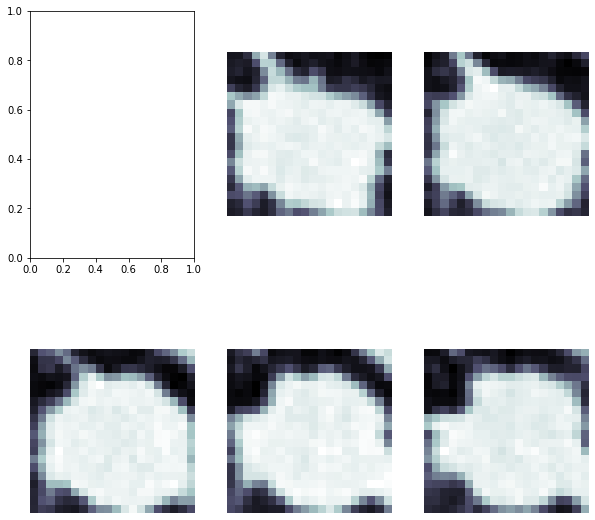

In [0]:
plot_cubic("Out/images_1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd_199_size10x10.npy")

In [0]:
# The locations of the nodes
df_node = pd.read_csv(anno_path)
df_node["file"] = df_node["seriesuid"].apply(get_filename)
df_node = df_node.dropna()
df_node.head(5)

seriesuid  ...                                               file
9310  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.1057566...
9311  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.1057566...
9312  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.1057566...
9313  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.1057566...
9314  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.1057566...

[5 rows x 6 columns]

In [0]:
df_node.shape

(56938, 6)

In [0]:
'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

In [0]:
'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

We want to extract now some features from the candidates. We define some normalized planes to extract views from the candidates

In [0]:
def normalizePlanes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

## 3D https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial

In [0]:
import scipy.ndimage

def resample(image, spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    #spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [0]:
pix_resampled, new_spacing = resample(ct_scan, spacing, [1,1,1])
print("Shape before resampling\t", ct_scan.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (133, 512, 512)
Shape after resampling	 (332, 380, 380)


In [0]:
from skimage import measure, morphology
#https://stackoverflow.com/questions/54056565/attributeerror-module-skimage-measure-has-no-attribute-marching-cubes
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
#https://stackoverflow.com/questions/56222259/valueerror-unknown-projection-3d-once-again/56222305
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

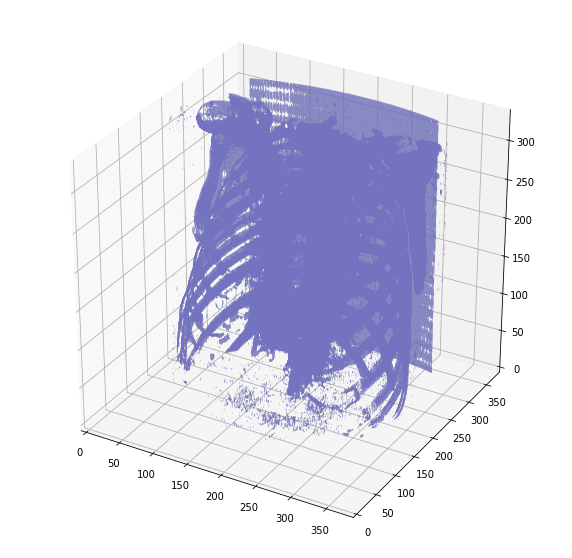

In [0]:
plot_3d(pix_resampled, 400)

## Segmentation of Lungs


https://github.com/booz-allen-hamilton/DSB3Tutorial/blob/master/tutorial_code/LUNA_mask_extraction.py

In [0]:
from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
try:
    from tqdm import tqdm # long waits are not fun
except:
    print('TQDM does make much nicer wait bars...')
    tqdm = lambda x: x



In [0]:
#Some helper functions

def make_mask(center,diam,z,width,height,spacing,origin):
    '''
Center : centers of circles px -- list of coordinates x,y,z
diam : diameters of circles px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [0]:
def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))

In [0]:
mkdir Output

In [0]:
# Getting list of image files
#luna_path = "/home/jonathan/LUNA2016/"
luna_subset_path = "Data/" # subset0
output_path = "Output/"
labels_path = 'labels/'
file_list=glob(luna_subset_path+"*.mhd")

In [0]:
#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)

In [0]:
# The locations of the nodes
df_node = pd.read_csv(labels_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
df_node

seriesuid  ...                                               file
23    1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081978...
25    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025...
26    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025...
28    1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.1111721...
86    1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.1241544...
...                                                 ...  ...                                                ...
1125  1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.8682118...
1137  1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.8986425...
1138  1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.8986425...
1141  1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.9053719...
1180  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707...  ...  Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.9790830...

[112 rows x 6 columns]

In [0]:
#####
#
# Looping over the image files
#
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 3 slices
            imgs = np.ndarray([3,height,width],dtype=np.float32)
            masks = np.ndarray([3,height,width],dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                             int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
            np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            np.save(os.path.join(output_path,"masks_%04d_%04d.npy" % (fcount, node_idx)),masks)

100%|██████████| 89/89 [04:30<00:00,  2.66s/it]


In [0]:
ls


Data/  labels/  Output/  sample_data/  Unet/


In [0]:
import matplotlib.pyplot as plt

imgs = np.load(output_path+'images_0012_0490.npy')
masks = np.load(output_path+'masks_0012_0490.npy')
for i in range(len(imgs)):
    print("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(masks[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show()
    #raw_input("hit enter to cont : ")

FileNotFoundError: ignored

In [0]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
from glob import glob

working_path = output_path #"/home/jonathan/tutorial/"
file_list=glob(working_path+"images_*.npy")

for img_file in file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print( "on image", img_file)
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        #Standardize the pixel values
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std
        # Find the average pixel value near the lungs
        # to renormalize washed out images
        middle = img[100:400,100:400] 
        mean = np.mean(middle)  
        max = np.max(img)
        min = np.min(img)
        # To improve threshold finding, I'm moving the 
        # underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean
        #
        # Using Kmeans to separate foreground (radio-opaque tissue)
        # and background (radio transparent tissue ie lungs)
        # Doing this only on the center of the image to avoid 
        # the non-tissue parts of the image as much as possible
        #
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
        #
        # I found an initial erosion helful for removing graininess from some of the regions
        # and then large dialation is used to make the lung region 
        # engulf the vessels and incursions into the lung cavity by 
        # radio opaque tissue
        #
        eroded = morphology.erosion(thresh_img,np.ones([4,4]))
        dilation = morphology.dilation(eroded,np.ones([10,10]))
        #
        #  Label each region and obtain the region properties
        #  The background region is removed by removing regions 
        #  with a bbox that is to large in either dimnsion
        #  Also, the lungs are generally far away from the top 
        #  and bottom of the image, so any regions that are too
        #  close to the top and bottom are removed
        #  This does not produce a perfect segmentation of the lungs
        #  from the image, but it is surprisingly good considering its
        #  simplicity. 
        #
        labels = measure.label(dilation)
        label_vals = np.unique(labels)
        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
                good_labels.append(prop.label)
        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        #
        #  The mask here is the mask for the lungs--not the nodes
        #  After just the lungs are left, we do another large dilation
        #  in order to fill in a41nd out the lung mask 
        #
        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
        imgs_to_process[i] = mask
    np.save(img_file.replace("images","lungmask"),imgs_to_process)
    

on image Output/images_0080_1125.npy
on image Output/images_0031_0345.npy
on image Output/images_0020_0028.npy
on image Output/images_0076_0836.npy
on image Output/images_0025_0456.npy
on image Output/images_0023_0621.npy
on image Output/images_0027_0350.npy
on image Output/images_0054_0367.npy
on image Output/images_0073_0784.npy
on image Output/images_0009_0794.npy
on image Output/images_0033_0839.npy
on image Output/images_0027_0348.npy
on image Output/images_0017_0103.npy
on image Output/images_0086_1054.npy
on image Output/images_0043_0478.npy
on image Output/images_0015_1109.npy
on image Output/images_0062_0630.npy
on image Output/images_0057_0130.npy
on image Output/images_0067_0086.npy
on image Output/images_0079_0098.npy
on image Output/images_0028_1106.npy
on image Output/images_0053_1022.npy
on image Output/images_0071_0872.npy
on image Output/images_0065_1138.npy
on image Output/images_0046_1117.npy
on image Output/images_0011_1074.npy
on image Output/images_0037_1141.npy
o

In [0]:
#
#    Here we're applying the masks and cropping and resizing the image
#


file_list=glob(working_path+"lungmask_*.npy")
out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in file_list:
    print ("working on file ", fname)
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        #
        # Finding the global min and max row over all regions
        #
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img,[512,512])
            new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
            out_images.append(new_img)
            out_nodemasks.append(new_node_mask)

num_images = len(out_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(working_path+"testMasks.npy",final_masks[rand_i[:test_i]])

working on file  Output/lungmask_0029_0789.npy
working on file  Output/lungmask_0033_0838.npy
working on file  Output/lungmask_0018_0506.npy
working on file  Output/lungmask_0053_1022.npy
working on file  Output/lungmask_0048_0144.npy
working on file  Output/lungmask_0014_1049.npy
working on file  Output/lungmask_0043_0477.npy
working on file  Output/lungmask_0080_1123.npy
working on file  Output/lungmask_0027_0348.npy
working on file  Output/lungmask_0046_1117.npy
working on file  Output/lungmask_0052_0980.npy
working on file  Output/lungmask_0015_1109.npy
working on file  Output/lungmask_0060_0135.npy
working on file  Output/lungmask_0070_0897.npy
working on file  Output/lungmask_0046_1116.npy
working on file  Output/lungmask_0036_1013.npy
working on file  Output/lungmask_0081_0732.npy
working on file  Output/lungmask_0029_0790.npy
working on file  Output/lungmask_0058_0110.npy
working on file  Output/lungmask_0016_0988.npy
working on file  Output/lungmask_0011_1073.npy
working on fi

In [0]:
imgs = np.load(working_path + 'images_0012_0490.npy')
lungmask = np.load(working_path+'lungmask_0012_0490.npy')

for i in range(len(imgs)):
    print ("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(lungmask[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*lungmask[i],cmap='gray')
    plt.show()
    #raw_input("hit enter to cont : ")

FileNotFoundError: ignored

## Dice Ceofficient Cost function for Segmentation

In [0]:
from __future__ import print_function

import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, BatchNormalization
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

working_path = output_path

#K.image_data_format()  # Theano dimension ordering in this code
K.common.set_image_dim_ordering('th')

img_rows = 512
img_cols = 512

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)*200
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
# def get_unet():
#     inputs = Input((1,img_rows, img_cols))
#     conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
#     conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2),dim_ordering="th")(conv1)

#     conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
#     conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
#     conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
#     conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
#     conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

#     up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
#     #up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
#     conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
#     conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

#     up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
#     #up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
#     conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
#     conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

#     up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
#     #up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
#     conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
#     conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)
    
#     up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
#     #up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
#     conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
#     conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

#     conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

#     model = Model(input=inputs, output=conv10)

#     model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

#     return model

In [0]:
def get_unet():
    inputs = Input((1,img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2),dim_ordering="th")(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    #up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    #up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    #up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    #up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = BatchNormalization()(conv9)


    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [0]:
def train_and_predict(use_existing):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train = np.load(working_path+"trainImages.npy").astype(np.float32)
    imgs_mask_train = np.load(working_path+"trainMasks.npy").astype(np.float32)

    imgs_test = np.load(working_path+"testImages.npy").astype(np.float32)
    imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)
    
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean  # images should already be standardized, but just in case
    imgs_train /= std

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    # Saving weights to unet.hdf5 at checkpoints
    model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)
    #
    # Should we load existing weights? 
    # Set argument for call to train_and_predict to true at end of script
    if use_existing:
        model.load_weights('unet.hdf5')
        
    # 
    # The final results for this tutorial were produced using a multi-GPU
    # machine using TitanX's.
    # For a home GPU computation benchmark, on my home set up with a GTX970 
    # I was able to run 20 epochs with a training set size of 320 and 
    # batch size of 2 in about an hour. I started getting reseasonable masks 
    # after about 3 hours of training. 
    #
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=20, verbose=1, shuffle=True,
              callbacks=[model_checkpoint])

    # loading best weights from training session
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('unet.hdf5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    num_test = len(imgs_test)
    imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
    for i in range(num_test):
        imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0)[0]
    np.save('masksTestPredicted.npy', imgs_mask_test)
    mean = 0.0
    a = imgs_mask_test
    for i in range(num_test):
        mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])
    mean/=num_test
    print("Mean Dice Coeff : ",mean)
    return a


In [0]:
a = train_and_predict(False)

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), 

------------------------------
Fitting model...
------------------------------
Epoch 1/20
269/269 [==============================] - 19s 69ms/step - loss: -1.4314e-04 - dice_coef: 1.4314e-04
Epoch 2/20
269/269 [==============================] - 15s 55ms/step - loss: -4.7687e-04 - dice_coef: 4.7687e-04
Epoch 3/20
269/269 [==============================] - 15s 55ms/step - loss: -7.8915e-04 - dice_coef: 7.8915e-04
Epoch 4/20
269/269 [==============================] - 15s 55ms/step - loss: -0.0014 - dice_coef: 0.0014
Epoch 5/20
269/269 [==============================] - 15s 55ms/step - loss: -0.0021 - dice_coef: 0.0021
Epoch 6/20
269/269 [==============================] - 15s 55ms/step - loss: -0.0027 - dice_coef: 0.0027
Epoch 7/20
269/269 [==============================] - 15s 55ms/step - loss: -0.0032 - dice_coef: 0.0032
Epoch 8/20
269/269 [==============================] - 15s 55ms/step - loss: -0.0038 - dice_coef: 0.0038
Epoch 9/20
269/269 [==============================] - 15s 55ms/st

In [0]:
imgs_test_test = np.load(working_path+"trainImages.npy").astype(np.float32)
imgs_mask_test_true_true = np.load(working_path+"trainMasks.npy").astype(np.float32)

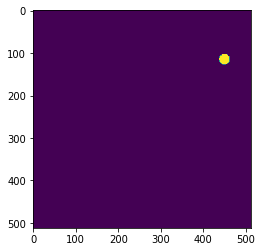

In [0]:
plt.imshow(imgs_mask_test_true_true[0][0])

In [0]:
testtt = new_modelll.predict(imgs_test_test)

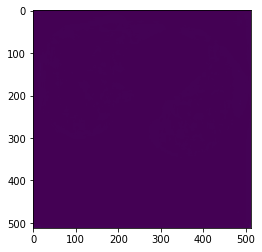

In [0]:
plt.imshow(testtt[0][0])

In [0]:
testtt[0][0].max()

0.014874518

In [0]:
imgs_mask_test_true_true[0][0].max()

0.003921569

In [0]:
imgs_testlllll = np.load(working_path+"testImages.npy").astype(np.float32)
imgs_testlllll.shape

(67, 1, 512, 512)

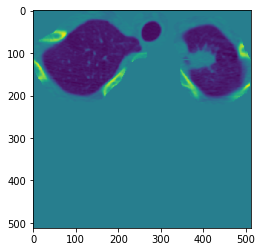

In [0]:
plt.imshow(imgs_testlllll[0][0])

In [0]:
imgs_mask_test_true11111 = np.load(working_path+"testMasks.npy").astype(np.float32)
#imgs_mask_test_true11111[0][0][30][:]

In [0]:
#np.save('test.npy',imgs_mask_test_true11111[0][0])

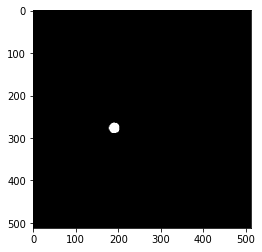

In [0]:
plt.imshow(imgs_mask_test_true11111[1][0], cmap='gray')

In [0]:
new_modelll = get_unet()
new_modelll.load_weights("unet.hdf5")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), 

In [0]:
testtt = new_modelll.predict(imgs_testlllll)

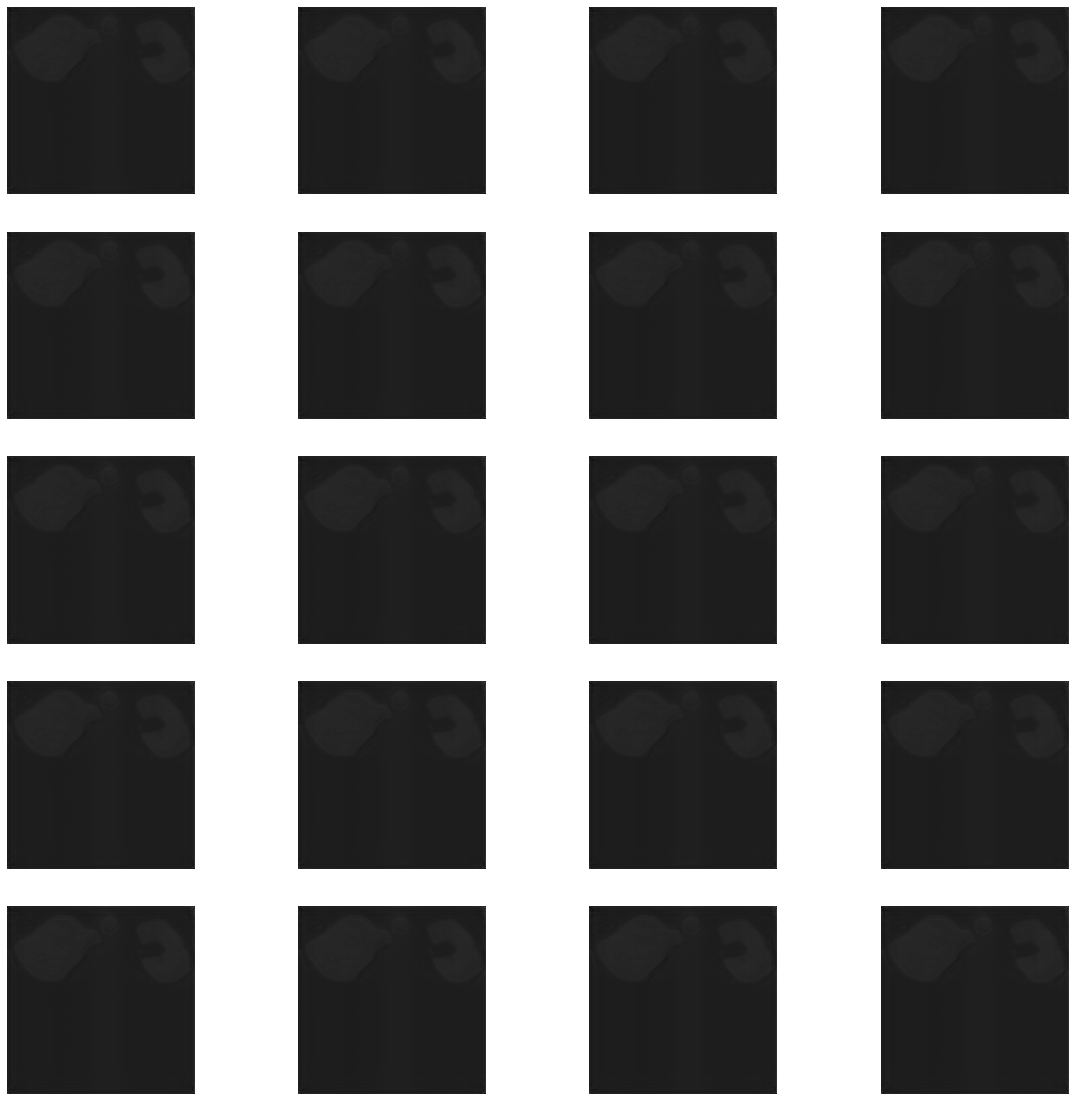

In [0]:
plot_ct_scan(testtt[0])

In [0]:
arrrr = np.load("masksTestPredicted.npy").astype(np.float32)
arrrr.shape

(67, 1, 512, 512)

In [0]:
np.where(a[0][0] > 0)

(array([  0,   0, 511, 511]), array([  0, 511,   0, 511]))

In [0]:
arrrr[0][0][511][:]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [0]:
imgs_mask_test_true11111[1][0][370][370]

0.0

In [0]:
np.where(imgs_mask_test_true11111[1][0]>0)

(array([112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113,
        113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114,
        114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114,
        114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115,
        115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116,
        116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,
        116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119,
        119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
        119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120

In [0]:
np.where(arrrr[0][0] > 0.0 )

(array([  0, 511]), array([  0, 511]))

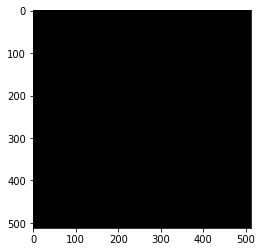

In [0]:
plt.imshow(arrrr[0][0],cmap='gray')

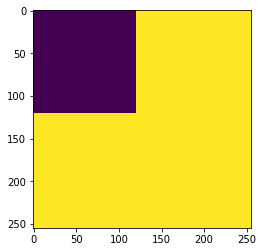

In [0]:
ar = np.ones((255,255))*0.016
ar[:120,:120] = ar[:120,:120] * 0
plt.imshow(ar)

In [0]:
imgs_mask_test_true11111[0][0].max()

0.003921569

In [0]:
(arrrr[0][0]*1000000).max()

25.987625122070312

In [0]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [0]:
ct_scan_hu = get_pixels_hu(ct_scan[100])

AttributeError: ignored

In [0]:
resemble

NameError: ignored

https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing#Segmentation-of-Lungs

After reading the CT Scan, the first step in preprocessing is the segmentation of lung structures because it is obvious that the regions of interests lies inside the lungs. It is visible that the lungs are the darker regions in the CT Scans. The bright region inside the lungs are the blood vessels or air. A threshold of 604(-400 HU) is used at all places because it was found in experiments that it works just fine. We segment lung structures from each slice of the CT Scan image and try not to loose the possible region of interests attached to the lung wall. There are some nodules which may be attached to the lung wall.

In [0]:
ct_scan[0].max()

1662

In [0]:
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.filters import roberts, sobel
from scipy import ndimage as ndi
HU = 604
def get_segmented_lungs(im, HU,plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < HU
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

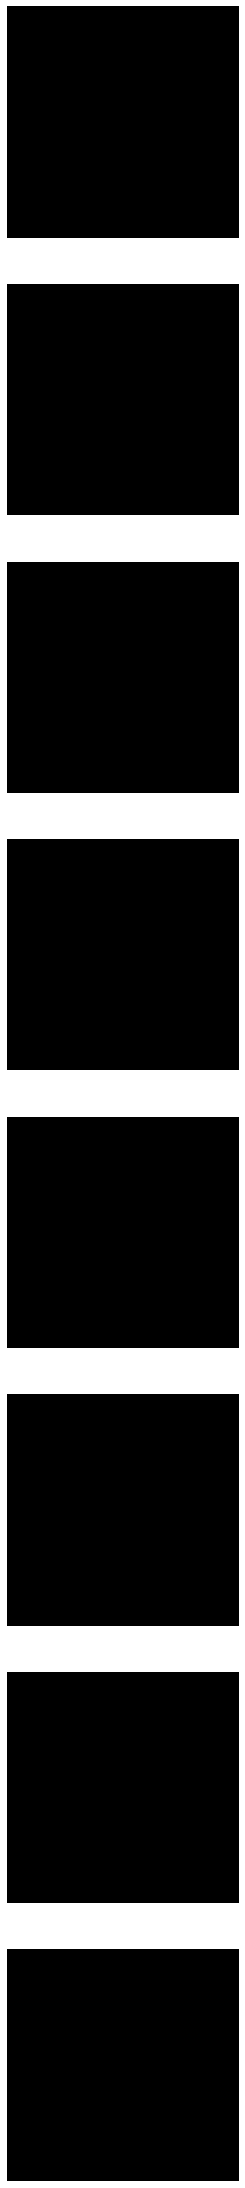

In [0]:
get_segmented_lungs(ct_scan[100].copy(),HU, True)


In [0]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice,HU) for slice in ct_scan])

In [0]:
segmented_ct_scan = segment_lung_from_ct_scan(ct_scan.copy())


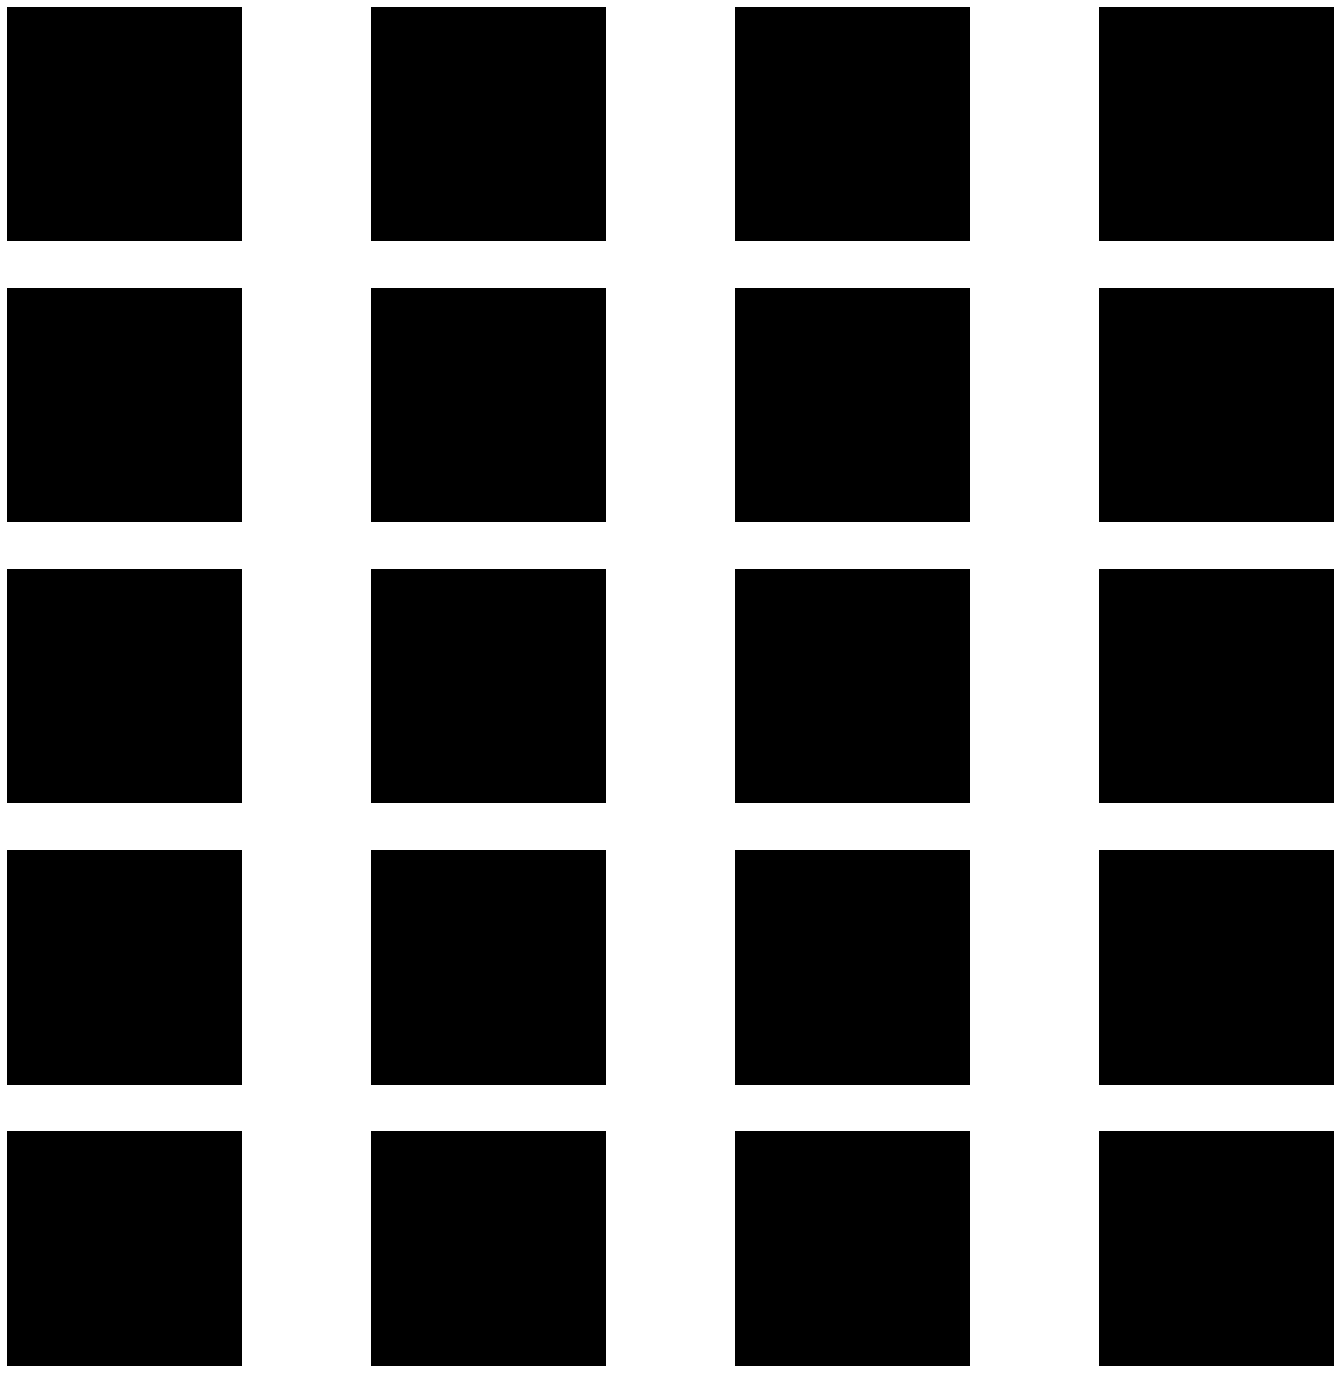

In [0]:
plot_ct_scan(segmented_ct_scan[130:150])
 

## Nodule Candidate/Region of Interest Generation¶


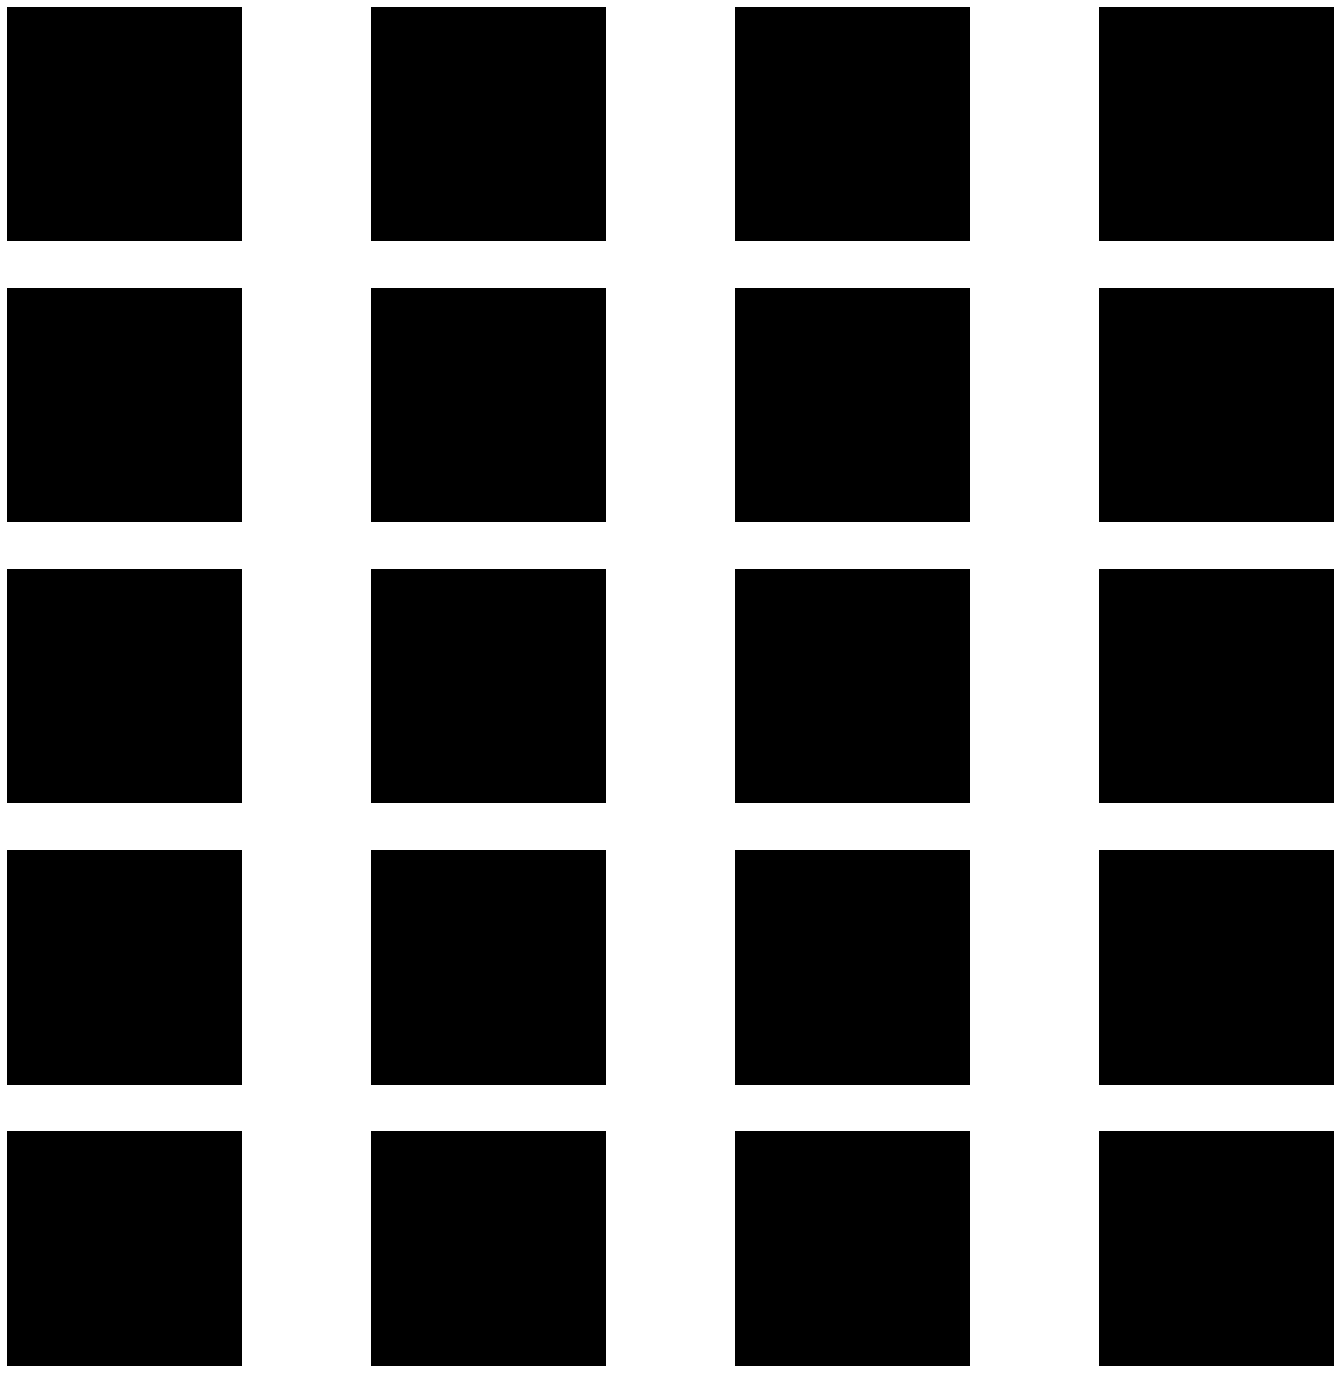

In [0]:
segmented_ct_scan[segmented_ct_scan < HU] = 0
plot_ct_scan(segmented_ct_scan)

In [0]:
selem = ball(2)
binary = binary_closing(segmented_ct_scan, selem)

label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 1000, 1000, 1000
    
    for c in r.coords:
        max_z = max(c[0], max_z)
        max_y = max(c[1], max_y)
        max_x = max(c[2], max_x)
        
        min_z = min(c[0], min_z)
        min_y = min(c[1], min_y)
        min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
        for c in r.coords:
            segmented_ct_scan[c[0], c[1], c[2]] = 0
    else:
        index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

In [0]:
def plot_33d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
   # p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [0]:
plot_33d(segment_lung_from_ct_scan(pix_resampled), 604)


ValueError: ignored

## UNET for Candidate Point Generation

In [0]:
m

In [0]:
m

In [0]:
!pip install dicom
import dicom

# Load the scans in given folder path
def load_scan_DCOM(path):
    #slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices = dicom.read_file(path,force=True)
    #slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [0]:
load_scan_DCOM("Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd")

KeyError: ignored

In [0]:
def seq(start, stop, step=1):
	n = int(round((stop - start)/float(step)))
	if n > 1:
		return([start + step*i for i in range(n+1)])
	else:
		return([])

'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
  #make empty matrix, which will be filled with the mask
  RESIZE_SPACING = [1, 1, 1]
  image_mask = np.zeros(image.shape)

	#run over all the nodules in the lungs
  for ca in cands.values:
		#get middel x-,y-, and z-worldcoordinate of the nodule
    radius = np.ceil(ca[4])/2
    coord_x = ca[1]
    coord_y = ca[2]
    coord_z = ca[3]
    image_coord = np.array((coord_z,coord_y,coord_x))

    #determine voxel coordinate given the worldcoordinate
    image_coord = world_2_voxel(image_coord,origin,spacing)

    #determine the range of the nodule
    noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

		#create the mask
    for x in noduleRange:
      for y in noduleRange:
        for z in noduleRange:
          coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
          if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
            image_mask[np.round(coords[0]),np.round(coords[1]),np.round(coords[2])] = int(1)
	
  return image_mask

'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, maskPath, cands):
	#if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
  img, origin, spacing = load_itk(imagePath)

  #calculate resize factor
  RESIZE_SPACING = [1, 1, 1]
  resize_factor = spacing / RESIZE_SPACING
  new_real_shape = img.shape * resize_factor
  new_shape = np.round(new_real_shape)
  real_resize = new_shape / img.shape
  new_spacing = spacing / real_resize

  #resize image
  lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
  lung_img = lung_img + 1024
  lung_mask = segment_lung_from_ct_scan(lung_img)
  lung_img = lung_img - 1024

  #create nodule mask
  nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

  lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

  original_shape = lung_img.shape	
  for z in range(lung_img.shape[0]):
    offset = (512 - original_shape[1])
    upper_offset = np.round(offset/2)
    lower_offset = offset - upper_offset

    new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

    lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
    lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
    nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
  np.save(imageName + '_lung_img.npz', lung_img_512)
  np.save(imageName + '_lung_mask.npz', lung_mask_512)
  np.save(imageName + '_nodule_mask.npz', nodule_mask_512)

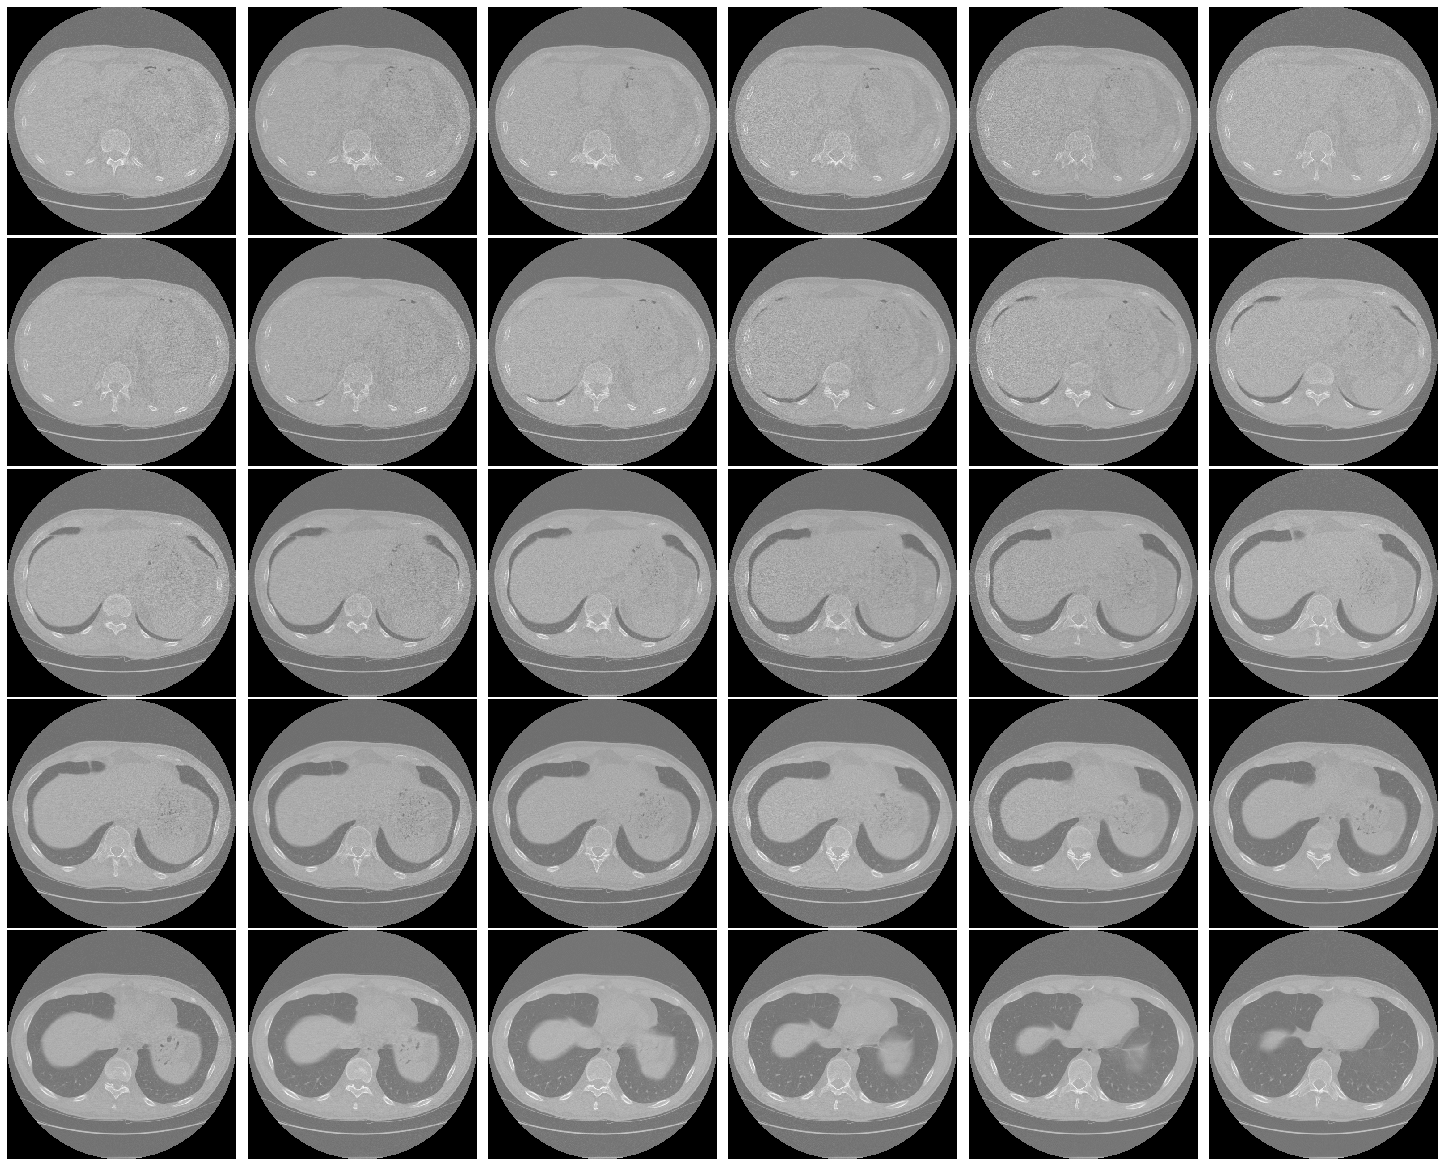

In [0]:
# import SimpleITK as sitk
# import matplotlib.pylab as plt
ct_scans = sitk.GetArrayFromImage(sitk.ReadImage("Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd", sitk.sitkFloat32))
plt.figure(figsize=(20,16))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.01,0.01)
for i in range(ct_scans.shape[0]):
    if i == 30 :
        break
    plt.subplot(5,6,i+1), plt.imshow(ct_scans[i]), plt.axis('off')
    # use plt.savefig(...) here if you want to save the images as .jpg, e.g.,
plt.show()